## 使用python库

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from talib.abstract import *
import seaborn as sbn
sbn.set()

## 参数

In [2]:
# Variable
timesteps = 8
batch_size = 16
units = 32
data_dim = 0
div_class = [-0.003, 0.003]
# div_class = [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]
num_classes = 3

idx_dict = {'中证500': 990905}
# idx_dict = {'沪深300': 300}
# idx_dict = {'上证50': 999987}
# idx_dict = {'上证50': 999987, '沪深300': 300, '中证500': 990905, '中小板指': 399005, '创业板指': 399006}
idxes = []
for name in idx_dict:
    idxes.append(idx_dict[name])
print('idxes: {0}'.format(idxes)) 

idxes: [990905]


## 数据处理

### 数据加载

In [3]:
def data_load():
    data_dir = '../data/'
    day_index1 = data_dir + '1day/index/2000_2009.csv'
    day_index2 = data_dir + '1day/index/2010_2016.csv'
    data1 = pd.read_csv(day_index1,encoding='gbk', parse_dates=['date'])
    data2 = pd.read_csv(day_index2,encoding='gbk', parse_dates=['date'])
    data = pd.concat([data1, data2])
    data.set_index(['code', 'date'], inplace=True)
    return data

In [4]:
data_all = data_load()

### 数据清理

In [5]:
def data_clean(data):
    new_data = pd.DataFrame()
    for column in ['open', 'high', 'low', 'close']:
        new_data[column] = data[column] / 10000.0

    # new_data.dropna(inplace=True)
    return new_data

### 数据转换

#### 转换函数

In [6]:
# 阴阳线
def stick_type(x):
    stick_type = -1
    if x['close'] >= x['open']:
        stick_type = 1
    return stick_type

# 上引线
def up_line(x):
    return x['high'] - x[['open','close']].max()

# 下引线
def down_line(x):
    return -(x[['open','close']].min() - x['low'])

# 实体长度
def body_size(x):
    return x['close'] - x['open']

def range_to_class(x):
    cls = []
    if x >= 0:
        for i in range(num_classes):
            if i == x:
                cls.append(1.0)
            else:
                cls.append(0.0)
    else:
        print(x)
        print("Error: n less than 0")
    return cls

In [7]:
# std_ration = 0.5
# def range_to_class(x):
#     df = pd.DataFrame(index=x.index)
#     df['close'] = x['close']
#     df['next_close'] = df['close'].shift(-1)
#     df['mean'] = df['close'].rolling(window=60, center=False, min_periods=60).mean()
#     df['std'] = df['close'].rolling(window=60, center=False, min_periods=60).std()
#     df.fillna(method='bfill', inplace=True)
#     df['down'] = df['mean'] - std_ration * df['std']
#     df['up'] = df['mean'] + std_ration * df['std']
#     df['class'] = np.nan
#     df.loc[df['next_close'] > df['up'], 'class'] = 2
#     df.loc[df['next_close'] < df['down'], 'class'] = 0
#     cond = (df['next_close'] <= df['up']) & (df['next_close'] >= df['down'])
#     df.loc[cond, 'class'] = 1
#     # last row has no next_close
#     new_data.dropna(inplace=True)
    
#     return df

#### 数据转换

In [8]:
std_ration = 0.01
def data_transform(data):
    new_data = pd.DataFrame()
    pre_close = data['close'].shift(1)
    for column in ['open', 'high', 'low', 'close']:
        new_data[column] = (data[column] - pre_close) / pre_close
        
    # add new feature
    # new_data['stick_type'] = new_data.apply(stick_type, axis=1)
    new_data['up_line'] = new_data.apply(up_line, axis=1)
    new_data['down_line'] = new_data.apply(down_line, axis=1)
    new_data['close_open'] = new_data.apply(body_size, axis=1)
    new_data.drop(['open', 'high', 'low'], axis=1, inplace=True)
    
    # ma
    # ma_lines = [5, 10, 20, 30]
    ma_lines = [5]
    pd_ma = pd.DataFrame(index=data.index)
    for ma_line in ma_lines:
        ma = MA(data.astype({'close': "double"}), price='close', timeperiod=ma_line)
        pd_ma['ma'+ str(ma_line)] = (ma - data['close']) / data['close']
    new_data = pd.concat([new_data, pd_ma], axis=1)
    new_data.dropna(inplace=True)
    
    # macd
#     macd = MACD(data.astype({'close': "double"}), price='close')
#     new_data = pd.concat([new_data, macd], axis=1)
#     new_data.dropna(inplace=True)
    
    # new_data['class'] = new_data.apply(range_to_class, axis=1)
    #new_data.dropna(inplace=True)
    
    df = pd.DataFrame()
    df['close'] = new_data['close']
    df['next_close'] = df['close'].shift(-1)
    df['mean'] = df['close'].rolling(window=60, center=False, min_periods=60).mean()
    df['std'] = df['close'].rolling(window=60, center=False, min_periods=60).std()
#     df['mean'] = df['close'].mean()
#     df['std'] = df['close'].std()
    
    df.fillna(method='bfill', inplace=True)
    df['down'] = df['mean'] - std_ration * df['std']
    df['up'] = df['mean'] + std_ration * df['std']
    df['class'] = np.nan
    df.loc[df['next_close'] > df['up'], 'class'] = 2
    df.loc[df['next_close'] < df['down'], 'class'] = 0
    cond = (df['next_close'] <= df['up']) & (df['next_close'] >= df['down'])
    df.loc[cond, 'class'] = 1
    new_data['class'] = df['class']
    # last row has no next_close
    new_data.dropna(inplace=True)
    
    # new_data['class']= new_data['class'].map(range_to_class)
        
#     # classes
#     new_data['class'] = new_data['close'].shift(-1)
#     # new_data.dropna(inplace=True)
#     new_data.fillna(0, inplace=True)
#     new_data['class']= new_data['class'].map(range_to_class)
        
    # new_data.dropna(inplace=True)
    return new_data

### 获取数据集

In [9]:
def get_data_set(data, codes):
    data_set = {}
    for code in codes:
        query_str = 'code=={0}'.format(code)
        data_match = data.query(query_str)
        data_cleaned = data_clean(data_match)
        data_transformed = data_transform(data_cleaned)
        print('code: {0}, data set len: {1}, start at: {2}, end at: {3}'.format(
            code, len(data_transformed), data_transformed.index[0],data_transformed.index[-1]))
        data_set[code] = data_transformed
    return data_set

In [10]:
data_set = get_data_set(data_all, idxes)

code: 990905, data set len: 2411, start at: (990905, Timestamp('2007-02-01 00:00:00')), end at: (990905, Timestamp('2016-12-29 00:00:00'))


In [11]:
data_set[idxes[0]].head()

close   up_line  down_line  close_open       ma5  class
code   date                                                                  
990905 2007-02-01  0.010506  0.005035  -0.018594    0.021185  0.017001    0.0
       2007-02-02 -0.017688  0.009665  -0.001296   -0.019824  0.029751    2.0
       2007-02-05  0.011822  0.006508  -0.001644    0.014048  0.007651    2.0
       2007-02-06  0.021368  0.000180  -0.004832    0.018465 -0.018679    2.0
       2007-02-07  0.018062  0.000000  -0.000580    0.012870 -0.027595    2.0

### 数据标准化

In [12]:
def normalize(data):
    new_data = data.copy()
    # norm_columns = ['close', 'ma5']
    norm_columns = ['close', 'close_open', 'ma5']
    # norm_columns = ['open', 'high', 'low', 'close', 'close_open']
    # norm_columns = ['open', 'high', 'low', 'close', 'close_open', 'macd', 'macdsignal', 'macdhist']
    for column in norm_columns:
        new_data[column] = preprocessing.scale(new_data[column])
        
    updown_line_values = new_data.loc[:,['up_line', 'down_line']].values
    updown_line_values_norm = preprocessing.scale(updown_line_values.reshape((-1,1))).reshape((-1, 2))
    updown_df = pd.DataFrame(index=new_data.index, columns=['up_line', 'down_line'], data=updown_line_values_norm)
    new_data['up_line'] = updown_df['up_line']
    new_data['down_line'] = updown_df['down_line']
        
    return new_data

In [13]:
data_set_norm = {}
for code in data_set:
    data_set_norm[code] = normalize(data_set[code])

In [14]:
data_set_norm[idxes[0]].head()

close   up_line  down_line  close_open       ma5  class
code   date                                                                  
990905 2007-02-01  0.451982  0.768624  -2.265240    0.952198  0.675936    0.0
       2007-02-02 -0.845257  1.363019  -0.044250   -1.063514  1.172947    2.0
       2007-02-05  0.512502  0.957765  -0.089016    0.601361  0.311436    2.0
       2007-02-06  0.951732  0.145214  -0.498234    0.818476 -0.715020    2.0
       2007-02-07  0.799634  0.122127   0.047715    0.543486 -1.062584    2.0

### 数据分割

In [15]:
def split_data(data, date, timesteps, batch_size):
    min_num = int(batch_size) * int(timesteps)
    
    train_query_str = 'date <= "{}"'.format(date)
    test_query_str = 'date > "{}"'.format(date)
    
    train = data.query(train_query_str)
    test = data.query(test_query_str)
    
    train_size = len(train)
    test_size = len(test)
    print('split set to train size: {0}, test size: {1}'.format(train_size, test_size))
    
    train_batchs = int(train_size / min_num)
    test_batchs = int(test_size / min_num)
    
    if train_batchs > 0:
        train = train[-(train_batchs * min_num + 1):-1]
    else:
        train = None

    if test_batchs > 0:
        test = test[0:test_batchs * min_num]
    else:
        test = None
    
    print("train set len: {0}, start at {1}, end at {2}".format(len(train), train.index.get_level_values('date')[0], train.index.get_level_values('date')[-1]))
    print("test set len: {0}, start at {1}, end at {2}".format(len(test), test.index.get_level_values('date')[0], test.index.get_level_values('date')[-1])) 
    return train, test

In [16]:
df_train_set = {}
df_test_set = {}

for code in data_set_norm:
    print('spliting code: {0}'.format(code))
    train, test = split_data(data_set_norm[code], '20141120', timesteps=timesteps, batch_size=batch_size)
    df_train_set[code] = train
    df_test_set[code] = test

spliting code: 990905
split set to train size: 1895, test size: 516
train set len: 1792, start at 2007-07-09 00:00:00, end at 2014-11-19 00:00:00
test set len: 512, start at 2014-11-21 00:00:00, end at 2016-12-23 00:00:00


In [17]:
df_train_set[idxes[0]].columns

Index(['close', 'up_line', 'down_line', 'close_open', 'ma5', 'class'], dtype='object')

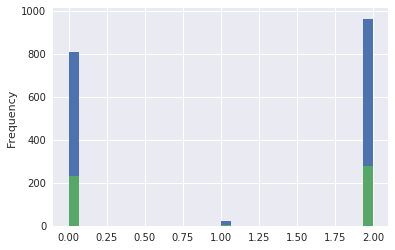

In [18]:
df_train_set[idxes[0]]['class'].plot.hist(bins=30)
df_test_set[idxes[0]]['class'].plot.hist(bins=30)

### 数据重整

In [19]:
def data_reform(data, batch_size, timesteps):
    data['class']= data['class'].map(range_to_class)
    data_values = data.values
    
    print("shape: {0}".format(data_values.shape))
    size = len(data_values)
    if size % (int(batch_size) * int(timesteps)) != 0:
        print("data size not match, size: {0}, batch_size: {1}, timesteps: {2}".format(size, batch_size, timesteps))
        return None, None
   
    X, Y0 = data_values[:, :-1], data_values[:, -1]
    
    X = X.reshape((-1, timesteps, X.shape[1]))
    
    Y = np.array([np.array(y) for y in Y0])
       
    Y = Y.reshape((-1, timesteps, Y.shape[1]))
    
    print("X.shape: {0} Y.shape: {1}".format(X.shape, Y.shape))
    
    return X, Y

In [20]:
train_set = {}
test_set = {}

for code in df_train_set:
    print(code)
    train_set[code] = data_reform(df_train_set[code], batch_size, timesteps)
                                  
for code in df_test_set:
    test_set[code] = data_reform(df_test_set[code], batch_size, timesteps)

990905
shape: (1792, 6)
X.shape: (224, 8, 5) Y.shape: (224, 8, 3)
shape: (512, 6)
X.shape: (64, 8, 5) Y.shape: (64, 8, 3)


## 数据分析

In [21]:
# data_all = data_load()

In [22]:
# idx_dict = {'上证50': 999987, '沪深300': 300, '中证500': 990905, '中小板指': 399005, '创业板指': 399006}

In [23]:
# # 确认指数代码
# for idx_name in idx_dict:
#     print("name: {0}".format(idx_name))
#     Id = data_all[data_all['name'] == idx_name].index.get_level_values('code').unique()
#     print("Id: {0}".format(Id))

In [24]:
# years = pd.date_range('1/1/2006', periods=11, freq='A')

In [25]:
# def data_stat(data, years, idx_dict):
#     idxes_des = pd.DataFrame()
#     for name in idx_dict:
#         # print(name)
#         code = idx_dict[name]
#         query_code = 'code=={0}'.format(code)
#         # print("query code: {0}".format(query_code))
#         data_code = data.query(query_code)
#         data_code_c = data_clean(data_code)
#         data_code_t = data_transform(data_code_c)
#         idx_des = pd.DataFrame()
#         for year in years:
#             end_date = year
#             begin_date  = year.replace(month=1, day=1)
#             query_date = 'date>"{0}" & date < "{1}"'.format(begin_date, end_date)
#             # print("query date: {0}".format(query_date))
#             data_code_year = data_code_t.query(query_date)
#             describe = data_code_year.close.describe()
#             df_describe = describe.to_frame().reset_index()
#             df_describe['date'] = year
#             idx_des = pd.concat([idx_des, df_describe])
#         idx_des = idx_des.pivot(index='date', columns='index', values='close')    
#         idx_des['code'] = code
#         idxes_des = pd.concat([idxes_des, idx_des])
#     return idxes_des

In [26]:
# data_stat = data_stat(data_all, years, idx_dict)

In [27]:
# data_stat_d = data_stat.drop(['count', 'min', 'max', 'std'],axis=1).dropna()

In [28]:
# t = data_stat_d.reset_index().set_index(['code', 'date'])
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))
# t.loc[999987].plot(ax=axes[0, 0])
# t.loc[300].plot(ax=axes[0, 1])
# t.loc[990905].plot(ax=axes[1, 0])
# t.loc[399005].plot(ax=axes[1, 1])
# t.loc[399006].plot(ax=axes[2, 0])

## 模型

In [29]:
data_dim = len(data_set_norm[idxes[0]].columns) - 1

In [30]:
batch_size, timesteps, data_dim

(16, 8, 5)

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation

units = 16
model = Sequential()
# input layer
# activation='relu' 
dropout=0.2
# kernel_initializer="uniform"
model.add(LSTM(units, stateful=True, return_sequences=True, batch_input_shape=(batch_size, timesteps, data_dim)))
# hidden layer
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=dropout))
# model.add(LSTM(units, return_sequences=True, stateful=True, dropout=dropout))
# model.add(LSTM(units, return_sequences=True, stateful=True, dropout=dropout))

# 回归问题
# # output layer
# # model.add(Dense(no_classes, activation='softmax'))
# model.add(Dense(1, activation='sigmoid')) # or sigmoid?
# # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='RMSProp', loss='mse') #mse

# 分类问题
# output layer
model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(num_classes, kernel_initializer="uniform"))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))

from keras.optimizers import SGD, Adam, RMSprop
model.compile(optimizer=RMSprop(0.00002), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (16, 8, 16)               1408      
_________________________________________________________________
lstm_2 (LSTM)                (16, 8, 16)               2112      
_________________________________________________________________
dense_1 (Dense)              (16, 8, 3)                51        
Total params: 3,571
Trainable params: 3,571
Non-trainable params: 0
_________________________________________________________________


## 数据集

### 测试集

### 训练集

## 训练

In [32]:
from influxdb import InfluxDBClient
from influxdb import SeriesHelper
host = '183.136.205.102'
port = 38086
user = 'root'
password = 'root'
dbname = 'chq'

myclient = InfluxDBClient(host, port, user, password, dbname)

In [33]:
trainid = 1
class MySeriesHelper(SeriesHelper):
    # Meta class stores time series helper configuration.
    class Meta:
        # The client should be an instance of InfluxDBClient.
        client = myclient
        # The series name must be a string. Add dependent fields/tags in curly brackets.
        series_name = 'deeplearning.train' + str(trainid)
        # Defines all the fields in this time series.
        fields = ['loss', 'acc']
        # Defines all the tags for the series.
        tags = ['dtype', 'code', 'epoch']
        # Defines the number of data points to store prior to writing on the wire.
        bulk_size = 5
        # autocommit must be set to True when using bulk_size
        autocommit = True

In [34]:
def train(model, train_set, test_set, epochs, batch_size):
# def train():
    for e in range(epochs+1):
        for code in train_set:
            model.reset_states()
            print("epochs: {0}, code: {1}".format(e, code))
            train_X, train_Y = train_set[code]
            # print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
            # history = model.fit(train_X, train_Y, epochs=100, batch_size=batch_size, validation_data=(test_X, test_Y), verbose=1, shuffle=False)
            history = model.fit(train_X, train_Y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
            model.reset_states()  
            # result = {'type': 'train', 'code': code, 'train_loss': (e, history.history['loss'][-1]), 'train_acc': (e, history.history['acc'][-1])}
            MySeriesHelper(dtype="train", code=code, epoch = e, loss=history.history['loss'][-1], acc= history.history['acc'][-1])
            # print(result)
        MySeriesHelper.commit()
            # yield result
        for code in test_set:
            model.reset_states()
            test_X, test_Y = test_set[code]
            loss_and_metrics = model.evaluate(test_X, test_Y, batch_size=batch_size)
            model.reset_states()
            # result = {'type': 'test', 'code': code, 'test_loss': (e, loss_and_metrics[0]), 'test_acc': (e, loss_and_metrics[1])}
            MySeriesHelper(dtype="test", code=code, epoch = e, loss=loss_and_metrics[0], acc= loss_and_metrics[1])
            
            if e % 100 == 0:
                model.reset_states()
                predict_Y=model.predict(x=test_X, batch_size=batch_size)
                model.reset_states()
                predict_class = np.argmax(predict_Y,axis=2)
                cmp_predict = compare_test_set(data_all, code)
                cmp_predict['predict_class'] = predict_class.reshape((-1, ))
                cmp_predict['diff'] = cmp_predict['predict_class'] - cmp_predict['real_class']
                cmp_predict = cmp_predict.reset_index()
                cmp_predict = cmp_predict.reset_index()
                cmp_predict['color'] = cmp_predict['diff'].map(color)
                cmp_predict['predict_class'].plot.hist(title='predict_class')
                plt.show()
                cmp_predict['real_class'].plot.hist(title='real_class')
                plt.show()

                cmp_predict['next_close'] = cmp_predict['close'].shift(-1)
                cmp_predict['profit'] = cmp_predict['next_close'] - cmp_predict['close']
                cmp_predict['predict_profit'] = cmp_predict.apply(predict_profit, axis=1)
                cmp_predict['predict_profit'].cumsum().plot(figsize=(8, 6), color='b', title='predict_profit')
                long_profit = cmp_predict[cmp_predict['predict_class']==2]['predict_profit']
                if len(long_profit) > 0:
                    long_profit.cumsum().plot(color='r')
                short_profit = cmp_predict[cmp_predict['predict_class']==0]['predict_profit']
                if len(short_profit) > 0:
                    short_profit.cumsum().plot(color='g')
                plt.show()
                print(class_compare(cmp_predict))
                
                cmp_predict2 = cmp_predict.tail(256).copy()
                cmp_predict2['predict_profit'].cumsum().plot(figsize=(8, 6), color='b', title='predict_profit2')
                long_profit2 = cmp_predict2[cmp_predict2['predict_class']==2]['predict_profit']
                if len(long_profit2) > 0:
                    long_profit2.cumsum().plot(color='r')
                short_profit2 = cmp_predict2[cmp_predict2['predict_class']==0]['predict_profit']
                if len(short_profit2) > 0:
                    short_profit2.cumsum().plot(color='g')
                plt.show()
                print(class_compare(cmp_predict2))
            
            # print(result)
        MySeriesHelper.commit()
            # yield result
                # print("==================================")
                # print("loss_and_metrics: {0}".format(loss_and_metrics))
                # print("==================================")

#     def data_gen(t=0):
#         cnt = 0
#         while cnt < 1000:
#             cnt += 1
#             t += 0.1
#             yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)
# ani = animation.FuncAnimation(fig, run, train, repeat=False, init_func=init)
# plt.show()


epochs: 0, code: 990905
16/64 [======>.......................] - ETA: 0s

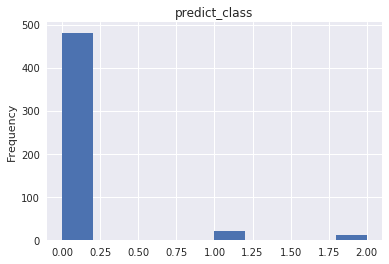

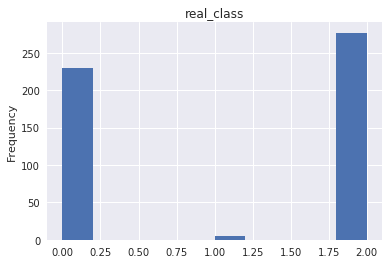

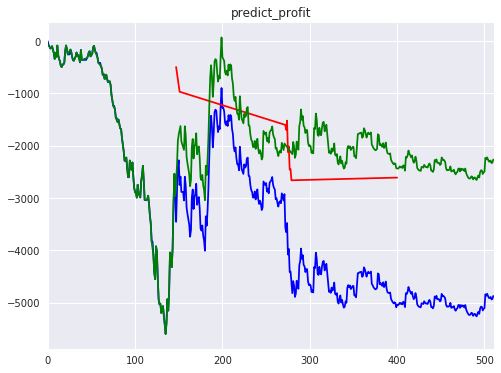

predict_class    0   1   2  All
real_class                     
0.0            218   5   7  230
1.0              3   2   0    5
2.0            260  13   4  277
All            481  20  11  512


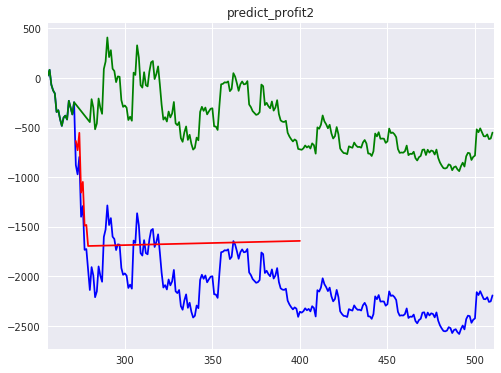

predict_class    0  2  All
real_class                
0.0            118  5  123
1.0              1  0    1
2.0            128  4  132
All            247  9  256
epochs: 1, code: 990905
16/64 [======>.......................] - ETA: 0s

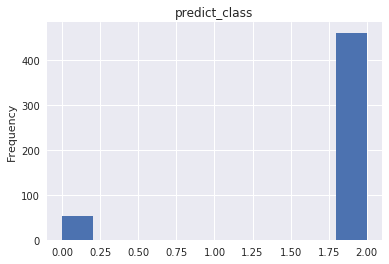

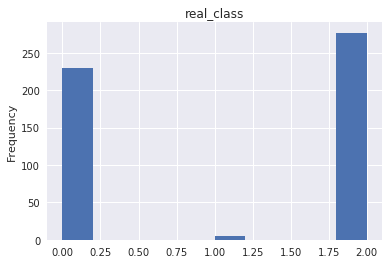

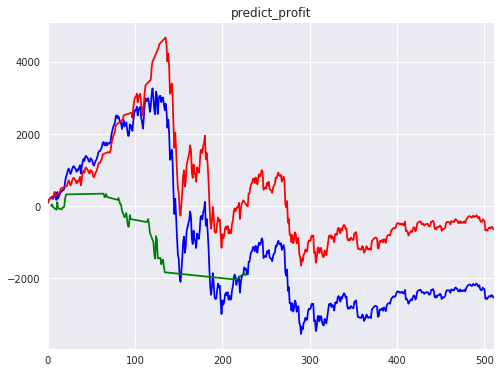

predict_class   0    2  All
real_class                 
0.0            25  205  230
1.0             0    5    5
2.0            27  250  277
All            52  460  512


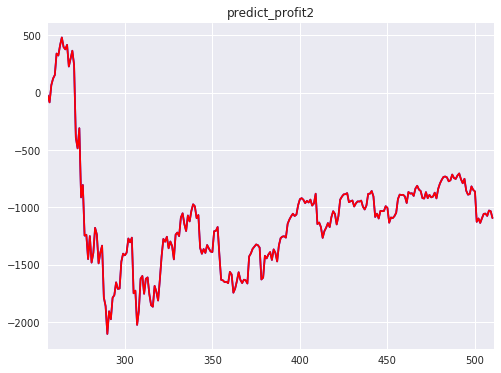

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 101, code: 990905
16/64 [======>.......................] - ETA: 0s

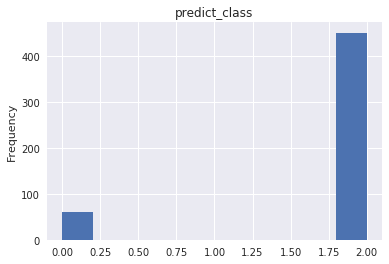

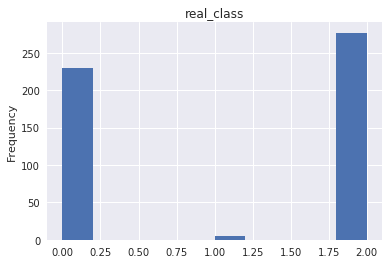

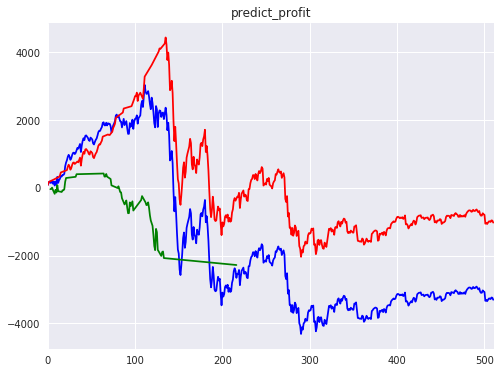

predict_class   0    2  All
real_class                 
0.0            28  202  230
1.0             0    5    5
2.0            33  244  277
All            61  451  512


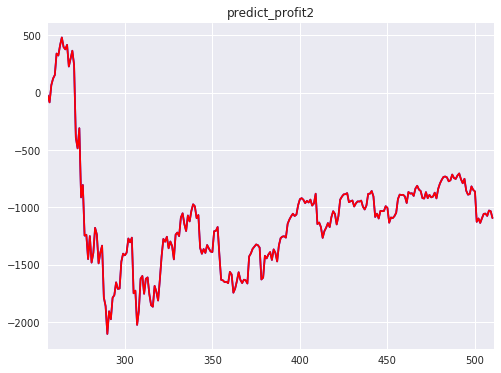

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 201, code: 990905
16/64 [======>.......................] - ETA: 0s

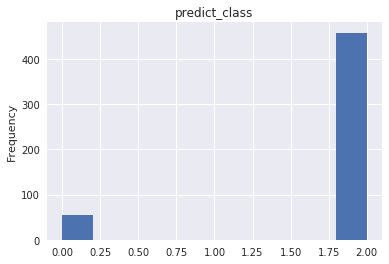

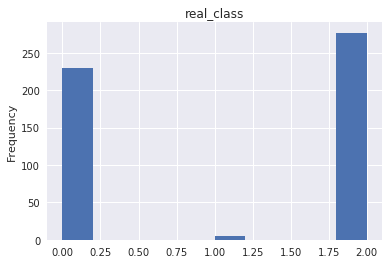

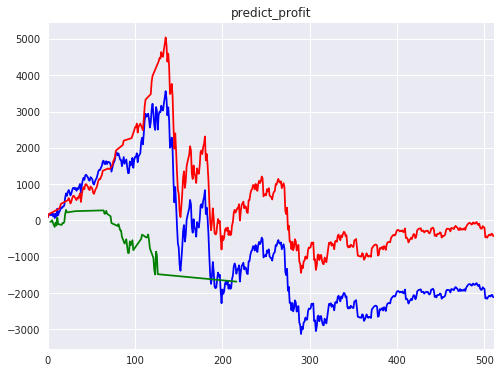

predict_class   0    2  All
real_class                 
0.0            25  205  230
1.0             0    5    5
2.0            29  248  277
All            54  458  512


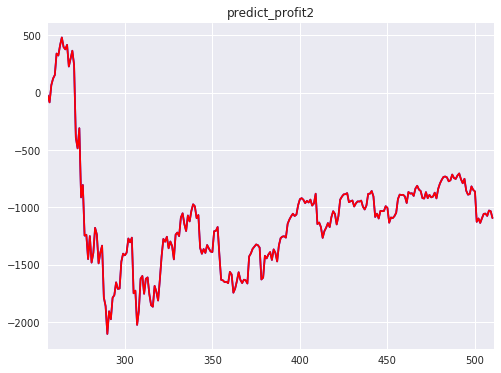

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 301, code: 990905
16/64 [======>.......................] - ETA: 0s

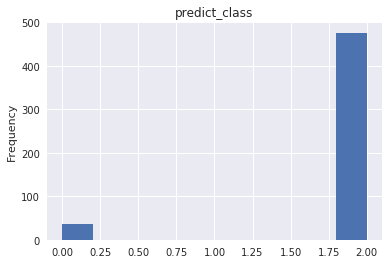

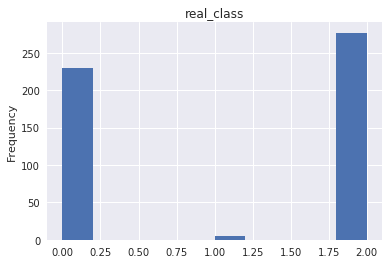

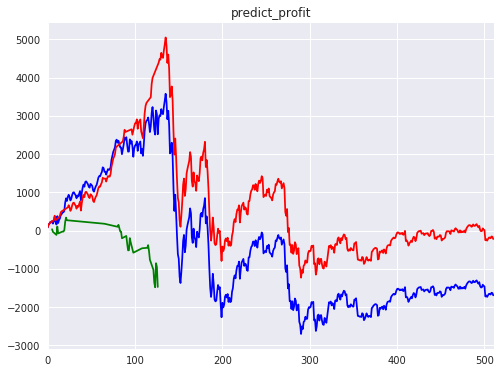

predict_class   0    2  All
real_class                 
0.0            16  214  230
1.0             0    5    5
2.0            20  257  277
All            36  476  512


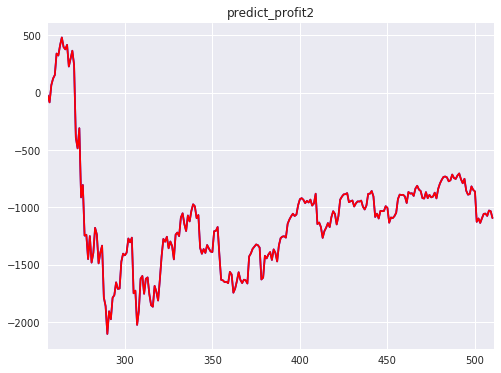

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 401, code: 990905
16/64 [======>.......................] - ETA: 0s

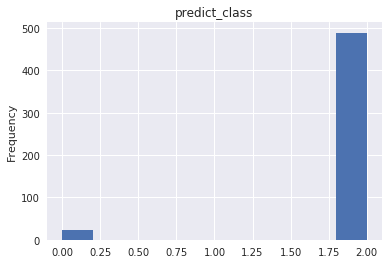

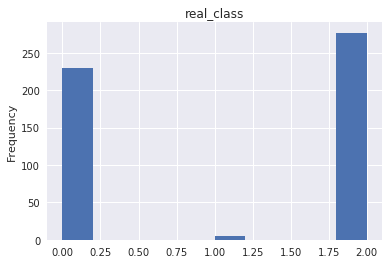

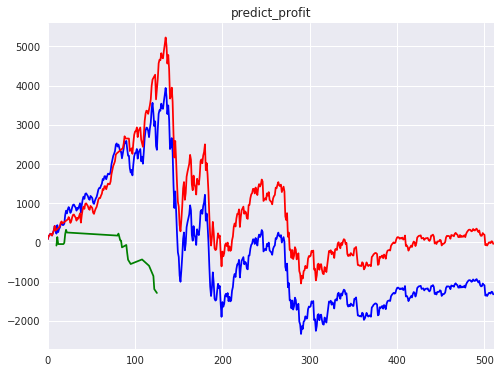

predict_class   0    2  All
real_class                 
0.0             9  221  230
1.0             0    5    5
2.0            14  263  277
All            23  489  512


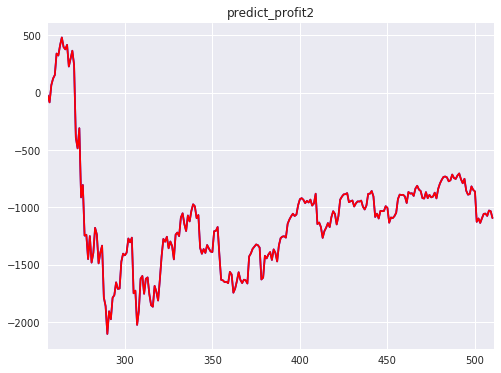

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 501, code: 990905
16/64 [======>.......................] - ETA: 0s

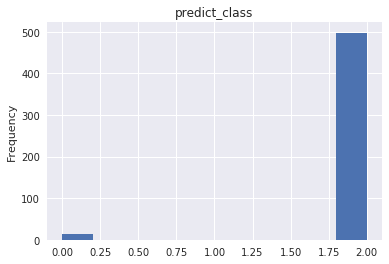

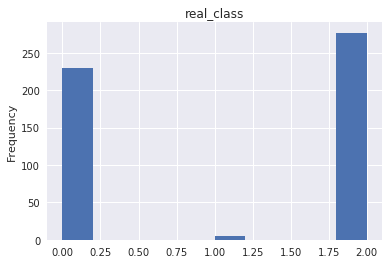

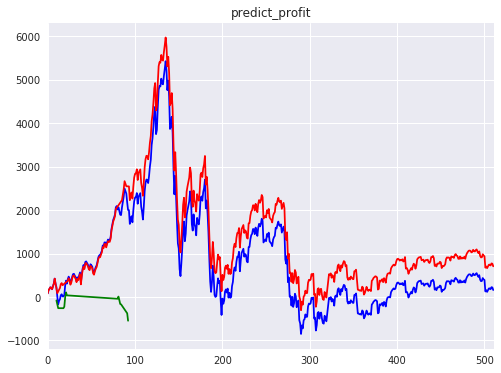

predict_class   0    2  All
real_class                 
0.0             6  224  230
1.0             0    5    5
2.0             8  269  277
All            14  498  512


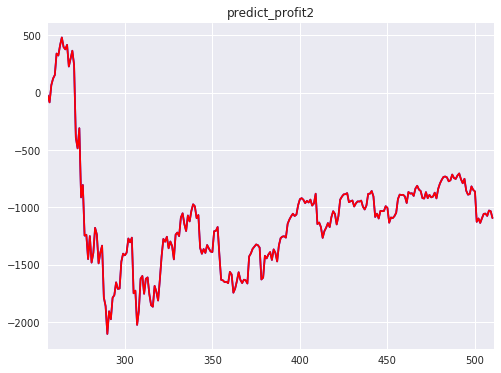

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 601, code: 990905
64/64 [==============================] - 0s     
epochs: 655, code: 990905
16/64 [======>.......................] - ETA: 0s

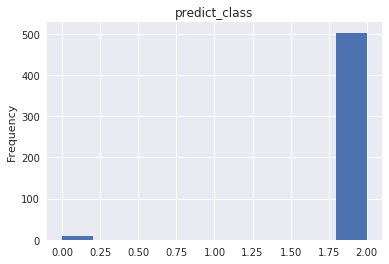

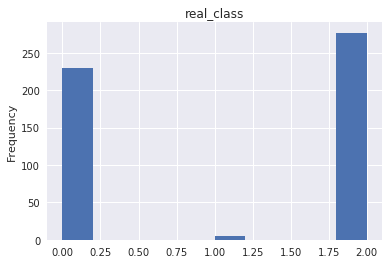

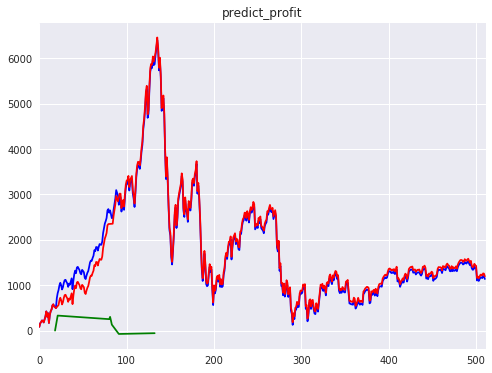

predict_class  0    2  All
real_class                
0.0            5  225  230
1.0            0    5    5
2.0            4  273  277
All            9  503  512


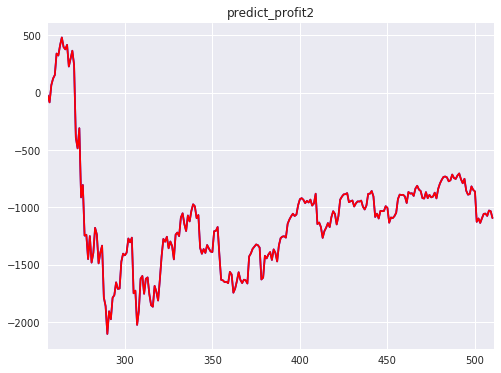

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 701, code: 990905
64/64 [==============================] - 0s     
epochs: 757, code: 990905
16/64 [======>.......................] - ETA: 0s

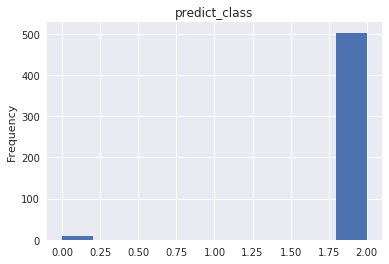

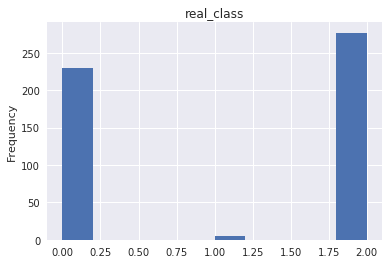

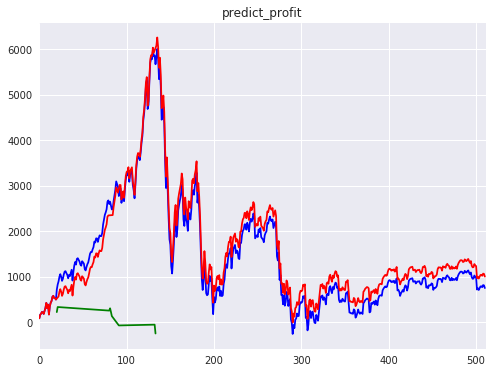

predict_class  0    2  All
real_class                
0.0            4  226  230
1.0            0    5    5
2.0            5  272  277
All            9  503  512


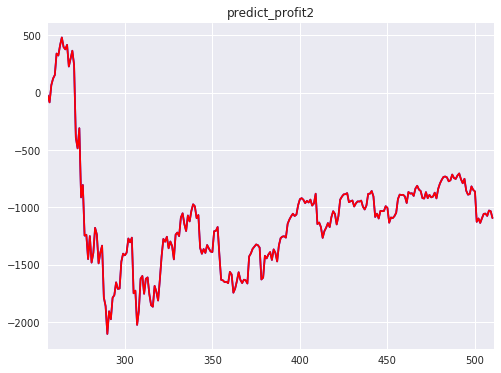

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 801, code: 990905
16/64 [======>.......................] - ETA: 0s

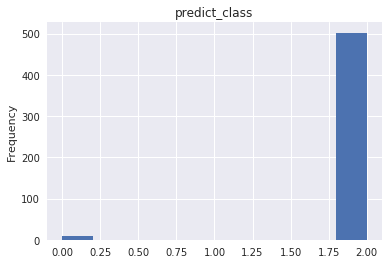

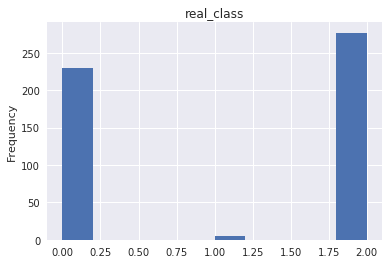

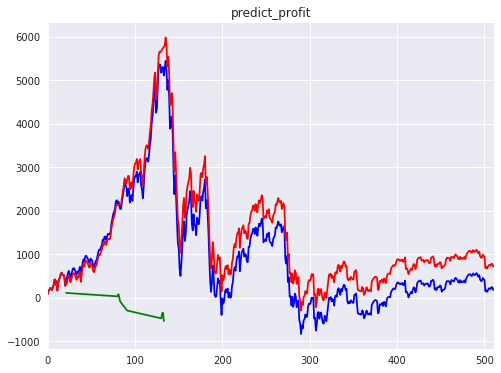

predict_class   0    2  All
real_class                 
0.0             4  226  230
1.0             0    5    5
2.0             6  271  277
All            10  502  512


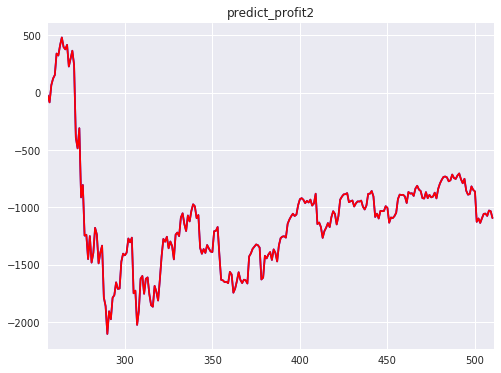

predict_class    2  All
real_class             
0.0            123  123
1.0              1    1
2.0            132  132
All            256  256
epochs: 901, code: 990905
16/64 [======>.......................] - ETA: 0s

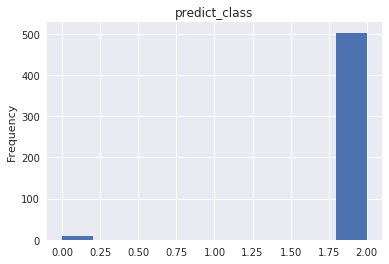

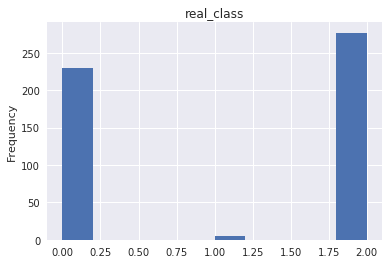

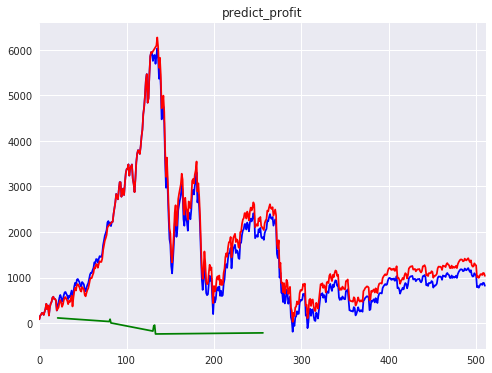

predict_class  0    2  All
real_class                
0.0            5  225  230
1.0            0    5    5
2.0            4  273  277
All            9  503  512


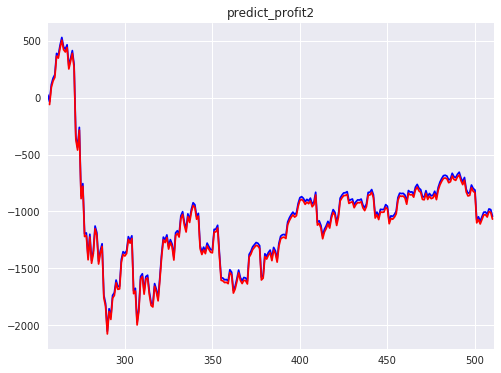

predict_class  0    2  All
real_class                
0.0            1  122  123
1.0            0    1    1
2.0            0  132  132
All            1  255  256
epochs: 1001, code: 990905
16/64 [======>.......................] - ETA: 0s

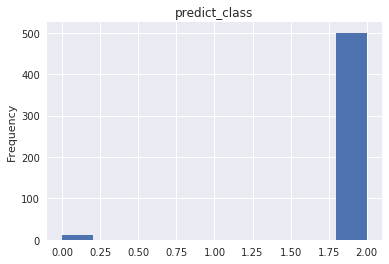

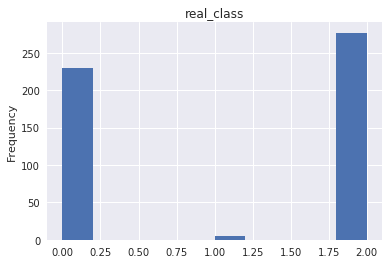

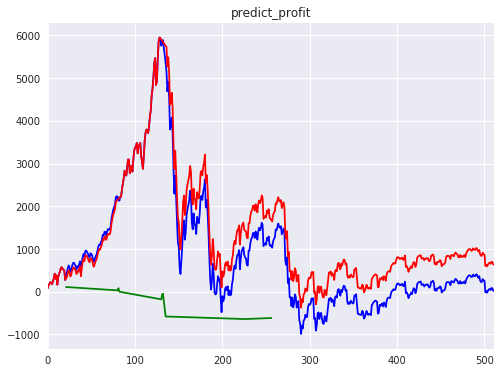

predict_class   0    2  All
real_class                 
0.0             5  225  230
1.0             0    5    5
2.0             7  270  277
All            12  500  512


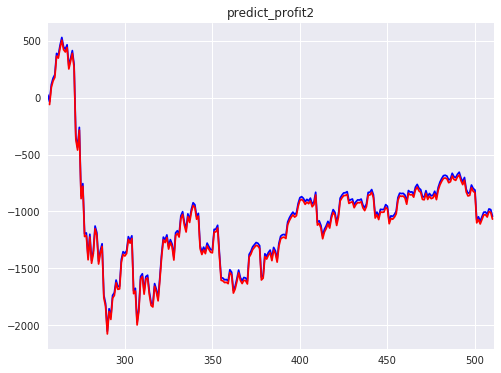

predict_class  0    2  All
real_class                
0.0            1  122  123
1.0            0    1    1
2.0            0  132  132
All            1  255  256
epochs: 1101, code: 990905
16/64 [======>.......................] - ETA: 0s

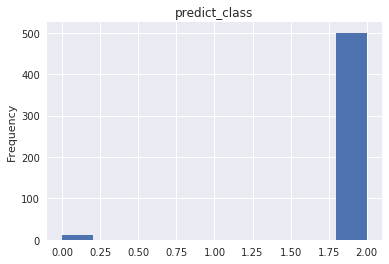

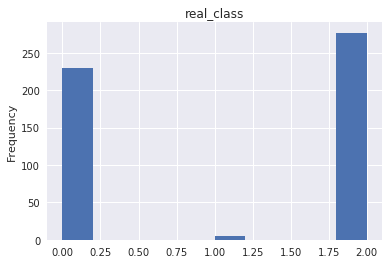

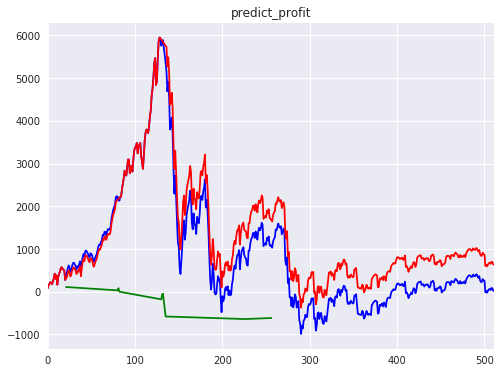

predict_class   0    2  All
real_class                 
0.0             5  225  230
1.0             0    5    5
2.0             7  270  277
All            12  500  512


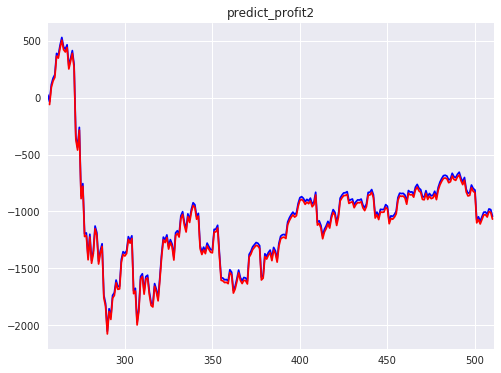

predict_class  0    2  All
real_class                
0.0            1  122  123
1.0            0    1    1
2.0            0  132  132
All            1  255  256
epochs: 1201, code: 990905
16/64 [======>.......................] - ETA: 0s

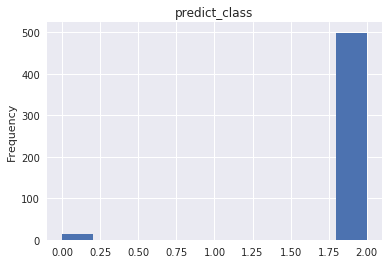

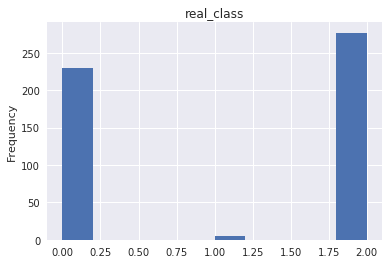

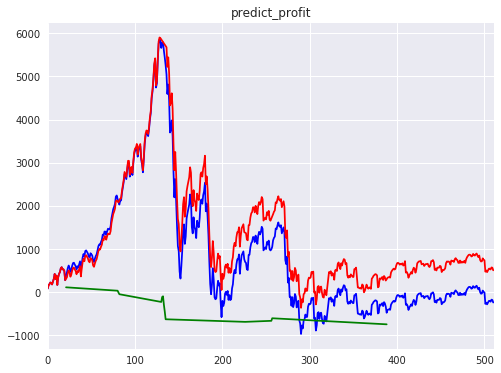

predict_class   0    2  All
real_class                 
0.0             5  225  230
1.0             0    5    5
2.0             8  269  277
All            13  499  512


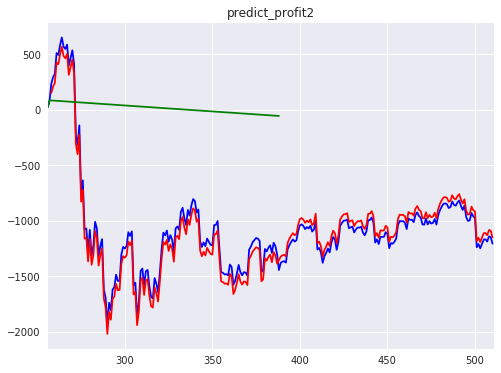

predict_class  0    2  All
real_class                
0.0            2  121  123
1.0            0    1    1
2.0            1  131  132
All            3  253  256
epochs: 1301, code: 990905
64/64 [==============================] - 0s     
epochs: 1324, code: 990905
16/64 [======>.......................] - ETA: 0s

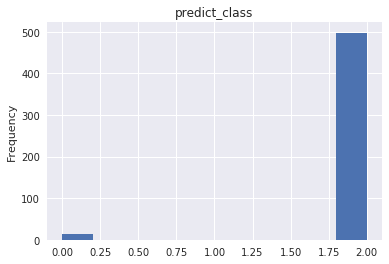

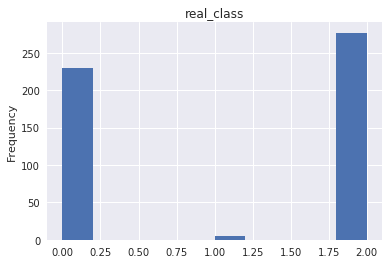

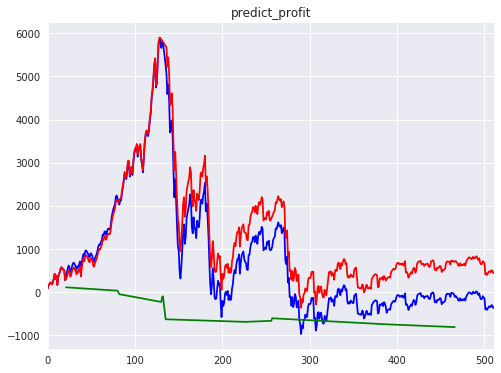

predict_class   0    2  All
real_class                 
0.0             5  225  230
1.0             0    5    5
2.0             9  268  277
All            14  498  512


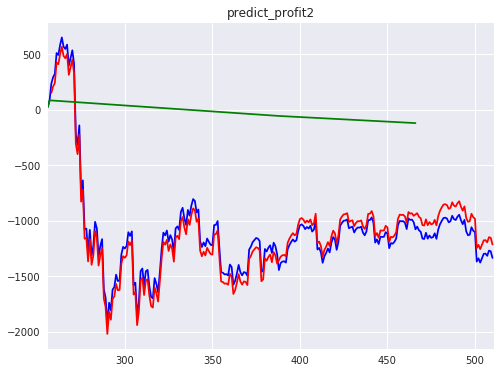

predict_class  0    2  All
real_class                
0.0            2  121  123
1.0            0    1    1
2.0            2  130  132
All            4  252  256
epochs: 1401, code: 990905
64/64 [==============================] - 0s     
epochs: 1447, code: 990905
16/64 [======>.......................] - ETA: 0s

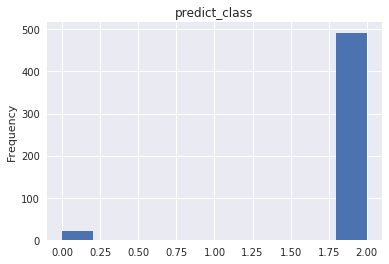

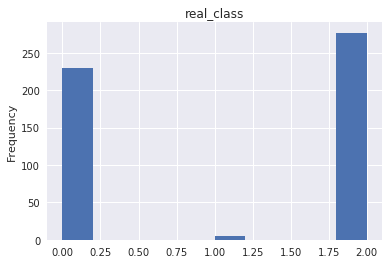

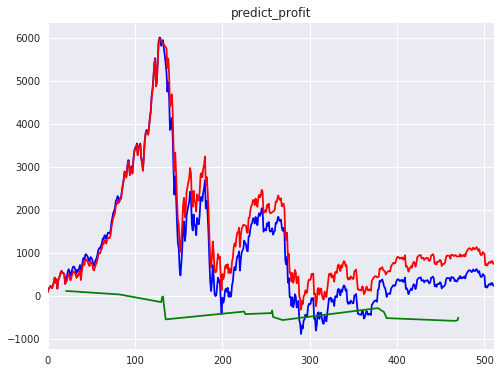

predict_class   0    2  All
real_class                 
0.0             9  221  230
1.0             0    5    5
2.0            11  266  277
All            20  492  512


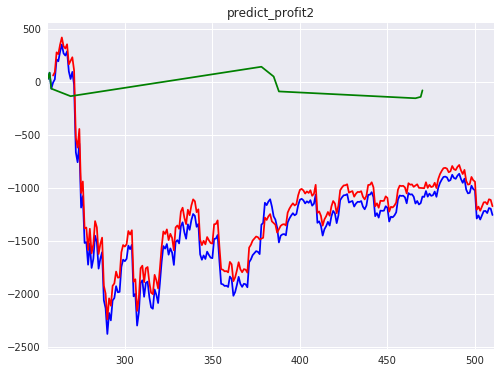

predict_class   0    2  All
real_class                 
0.0             5  118  123
1.0             0    1    1
2.0             5  127  132
All            10  246  256
epochs: 1501, code: 990905
16/64 [======>.......................] - ETA: 0s

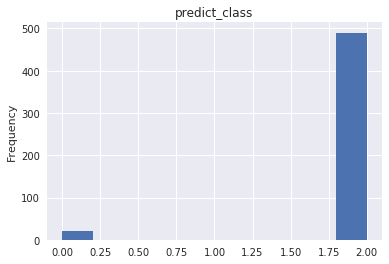

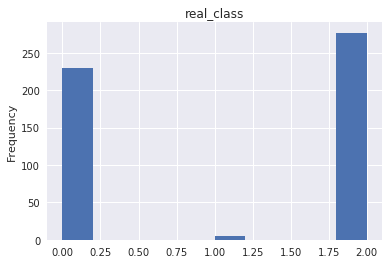

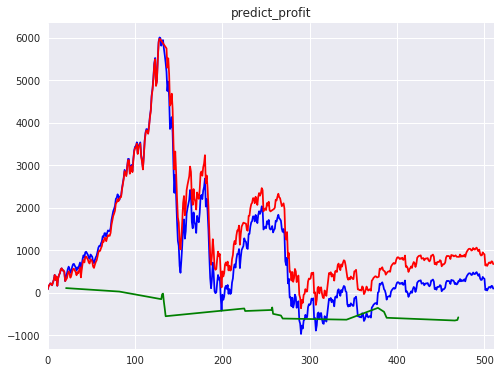

predict_class   0    2  All
real_class                 
0.0             9  221  230
1.0             0    5    5
2.0            13  264  277
All            22  490  512


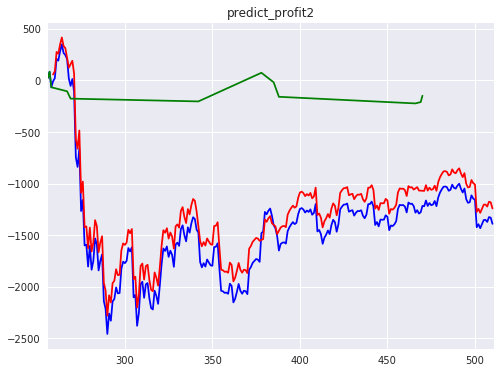

predict_class   0    2  All
real_class                 
0.0             5  118  123
1.0             0    1    1
2.0             7  125  132
All            12  244  256
epochs: 1601, code: 990905
16/64 [======>.......................] - ETA: 0s

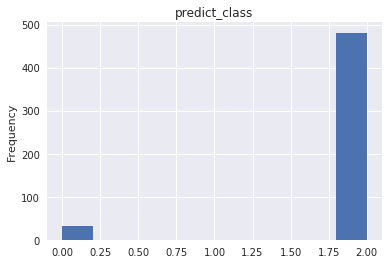

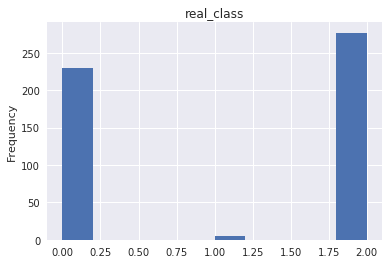

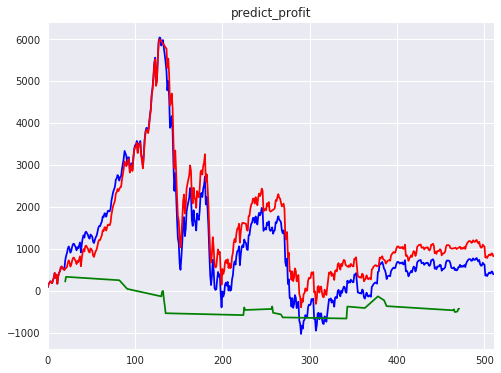

predict_class   0    2  All
real_class                 
0.0            13  217  230
1.0             0    5    5
2.0            18  259  277
All            31  481  512


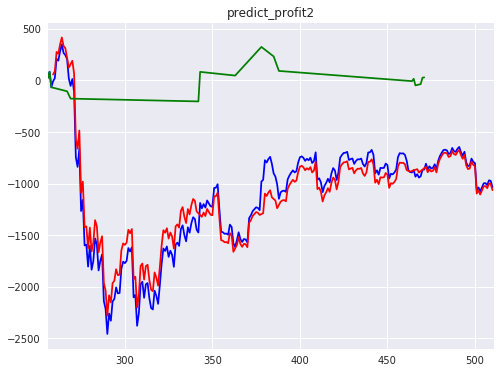

predict_class   0    2  All
real_class                 
0.0             8  115  123
1.0             0    1    1
2.0            10  122  132
All            18  238  256
epochs: 1701, code: 990905
16/64 [======>.......................] - ETA: 0s

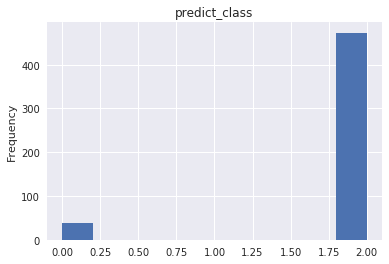

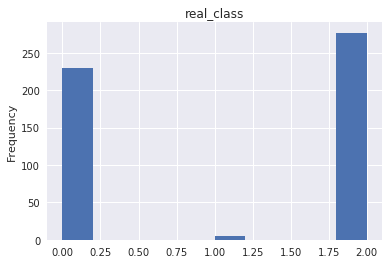

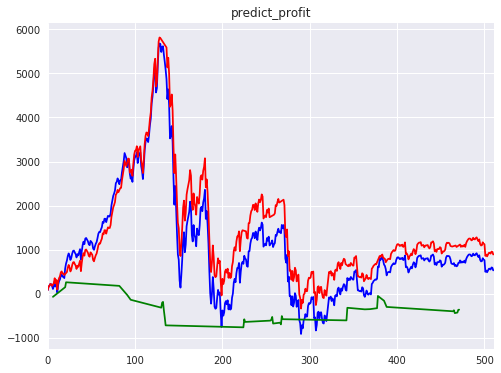

predict_class   0    2  All
real_class                 
0.0            18  212  230
1.0             0    5    5
2.0            21  256  277
All            39  473  512


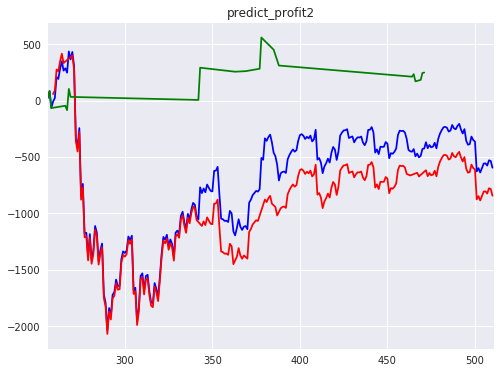

predict_class   0    2  All
real_class                 
0.0            12  111  123
1.0             0    1    1
2.0            11  121  132
All            23  233  256
epochs: 1801, code: 990905
16/64 [======>.......................] - ETA: 0s

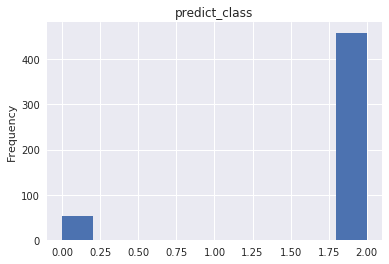

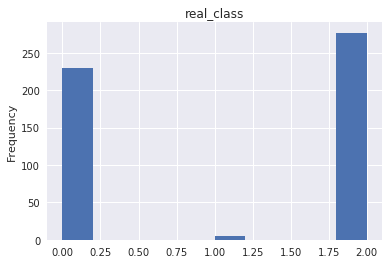

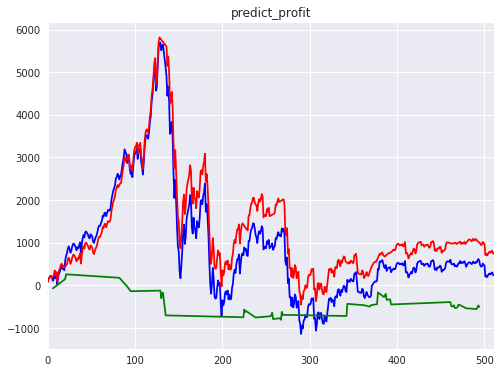

predict_class   0    2  All
real_class                 
0.0            26  204  230
1.0             0    5    5
2.0            27  250  277
All            53  459  512


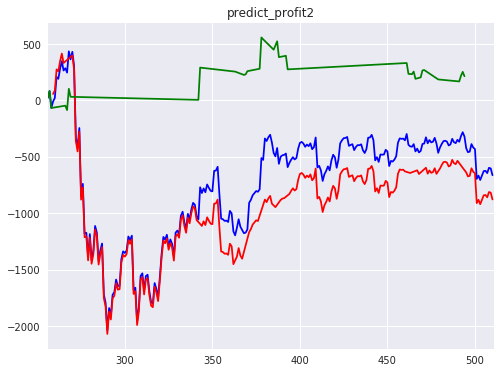

predict_class   0    2  All
real_class                 
0.0            18  105  123
1.0             0    1    1
2.0            16  116  132
All            34  222  256
epochs: 1901, code: 990905
64/64 [==============================] - 0s     
epochs: 1980, code: 990905
16/64 [======>.......................] - ETA: 0s

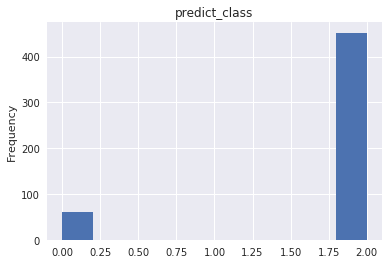

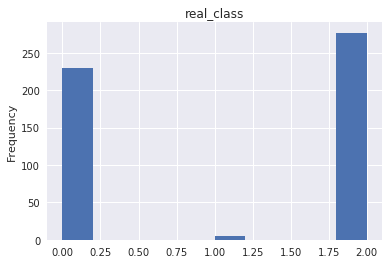

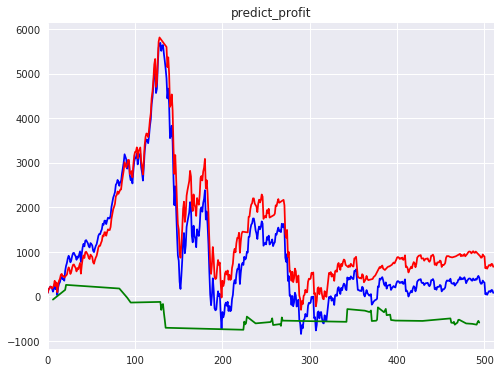

predict_class   0    2  All
real_class                 
0.0            30  200  230
1.0             0    5    5
2.0            30  247  277
All            60  452  512


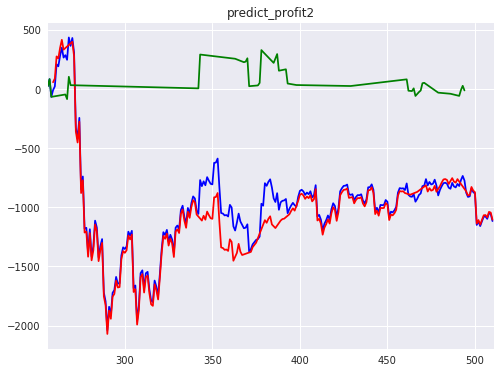

predict_class   0    2  All
real_class                 
0.0            21  102  123
1.0             0    1    1
2.0            19  113  132
All            40  216  256
epochs: 2001, code: 990905
16/64 [======>.......................] - ETA: 0s

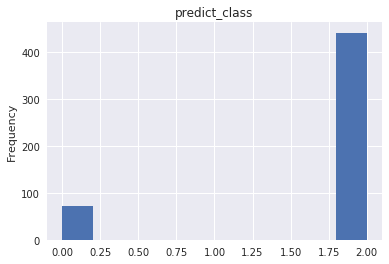

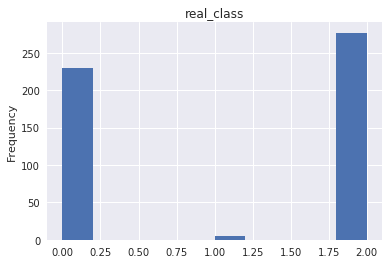

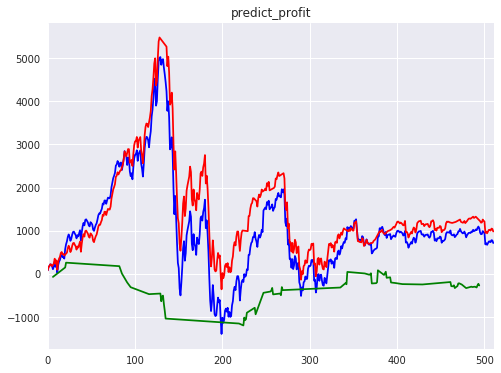

predict_class   0    2  All
real_class                 
0.0            36  194  230
1.0             0    5    5
2.0            35  242  277
All            71  441  512


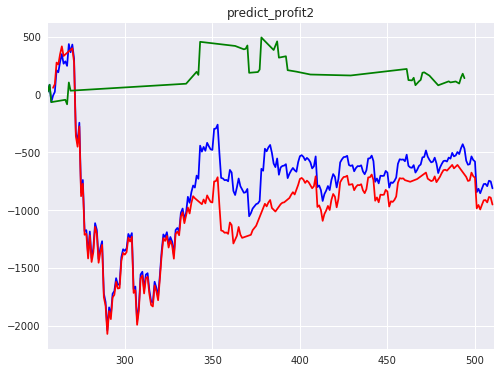

predict_class   0    2  All
real_class                 
0.0            25   98  123
1.0             0    1    1
2.0            21  111  132
All            46  210  256
epochs: 2101, code: 990905
16/64 [======>.......................] - ETA: 0s

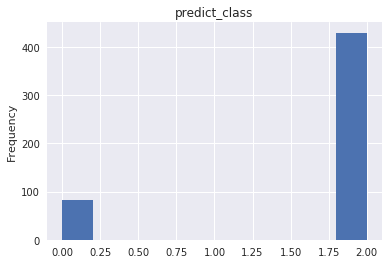

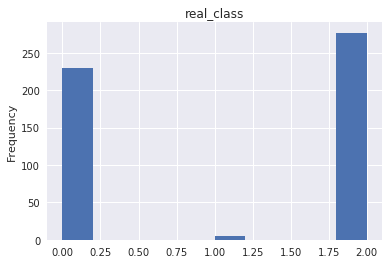

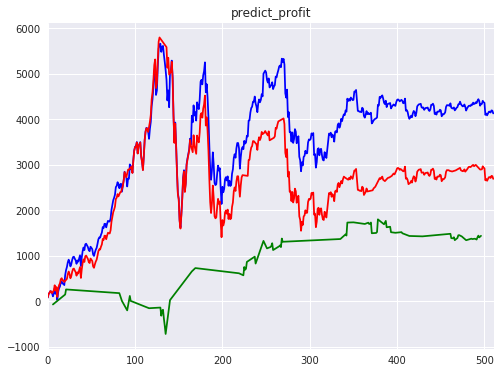

predict_class   0    2  All
real_class                 
0.0            45  185  230
1.0             0    5    5
2.0            38  239  277
All            83  429  512


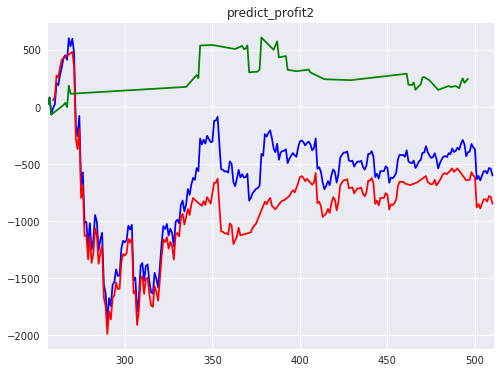

predict_class   0    2  All
real_class                 
0.0            30   93  123
1.0             0    1    1
2.0            23  109  132
All            53  203  256
epochs: 2201, code: 990905
64/64 [==============================] - 0s     
epochs: 2229, code: 990905
16/64 [======>.......................] - ETA: 0s

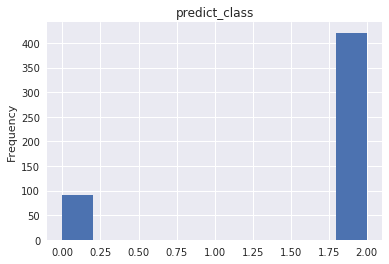

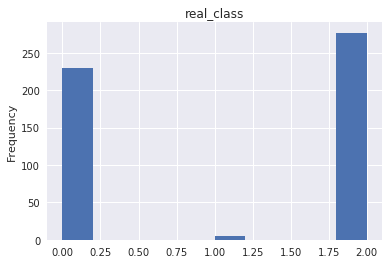

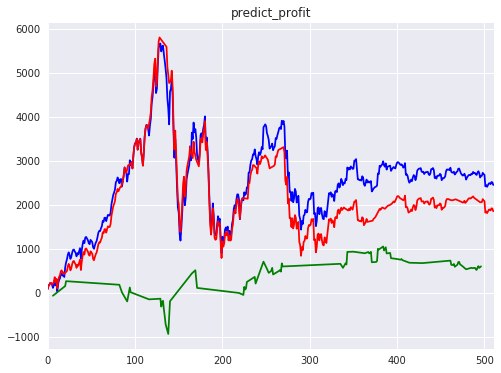

predict_class   0    2  All
real_class                 
0.0            46  184  230
1.0             0    5    5
2.0            45  232  277
All            91  421  512


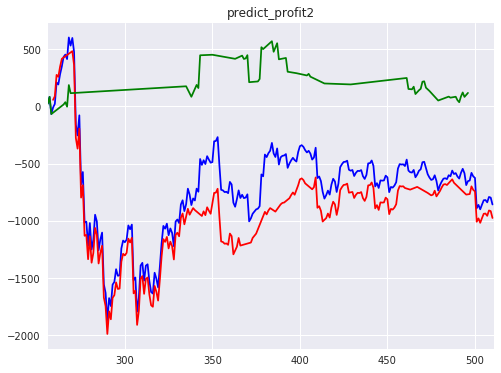

predict_class   0    2  All
real_class                 
0.0            31   92  123
1.0             0    1    1
2.0            27  105  132
All            58  198  256
epochs: 2301, code: 990905
16/64 [======>.......................] - ETA: 0s

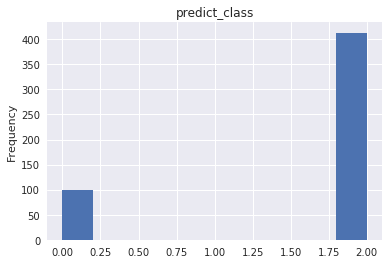

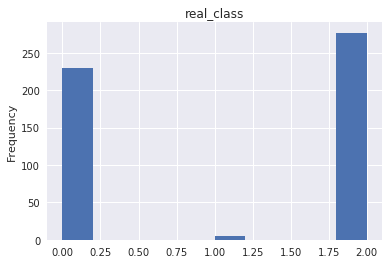

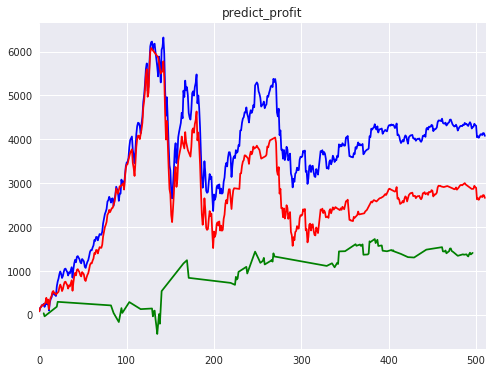

predict_class   0    2  All
real_class                 
0.0            52  178  230
1.0             0    5    5
2.0            47  230  277
All            99  413  512


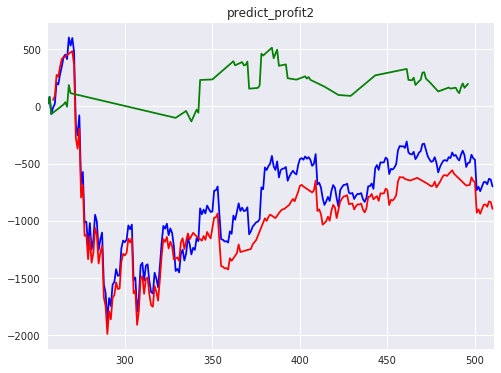

predict_class   0    2  All
real_class                 
0.0            34   89  123
1.0             0    1    1
2.0            29  103  132
All            63  193  256
epochs: 2401, code: 990905
16/64 [======>.......................] - ETA: 0s

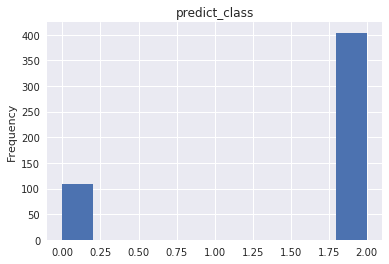

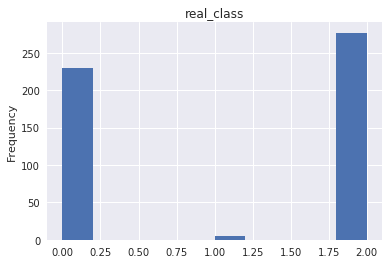

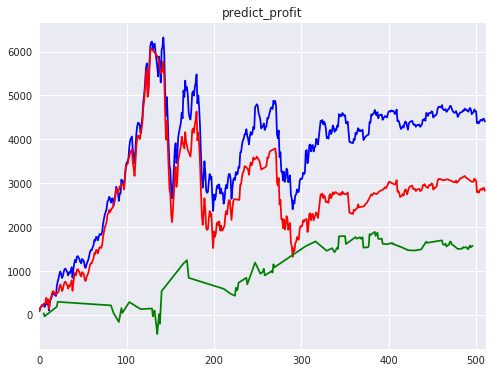

predict_class    0    2  All
real_class                  
0.0             56  174  230
1.0              0    5    5
2.0             52  225  277
All            108  404  512


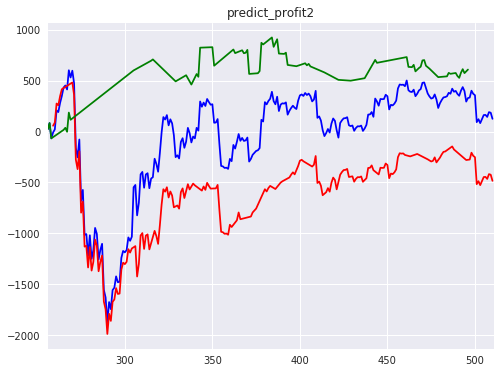

predict_class   0    2  All
real_class                 
0.0            38   85  123
1.0             0    1    1
2.0            33   99  132
All            71  185  256
epochs: 2501, code: 990905
64/64 [==============================] - 0s     
epochs: 2562, code: 990905
16/64 [======>.......................] - ETA: 0s

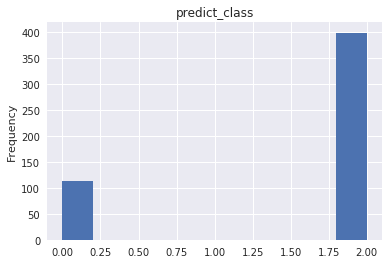

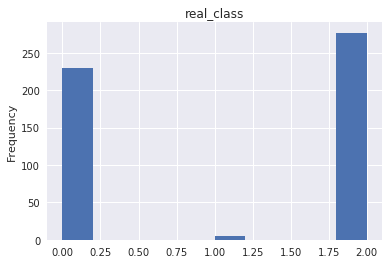

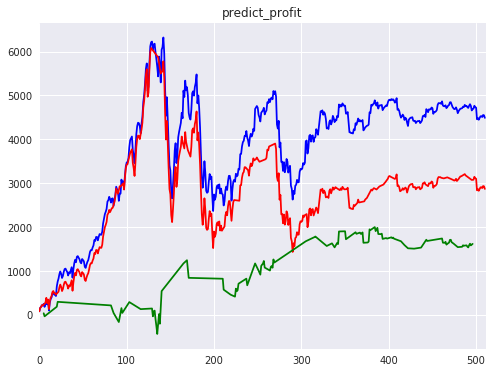

predict_class    0    2  All
real_class                  
0.0             58  172  230
1.0              0    5    5
2.0             55  222  277
All            113  399  512


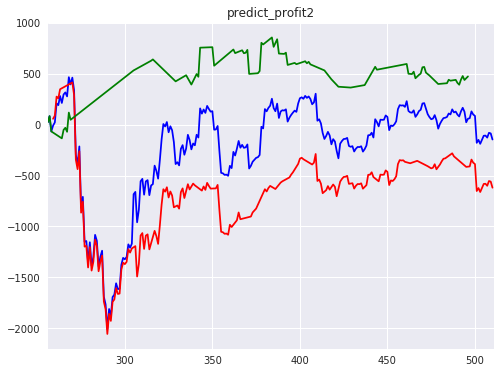

predict_class   0    2  All
real_class                 
0.0            39   84  123
1.0             0    1    1
2.0            35   97  132
All            74  182  256
epochs: 2601, code: 990905
16/64 [======>.......................] - ETA: 0s

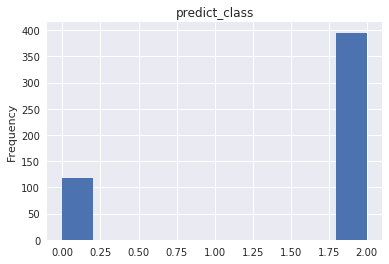

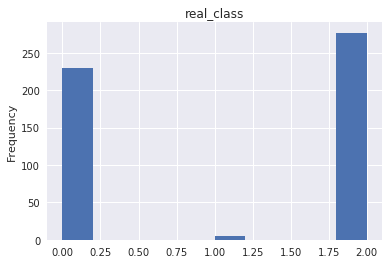

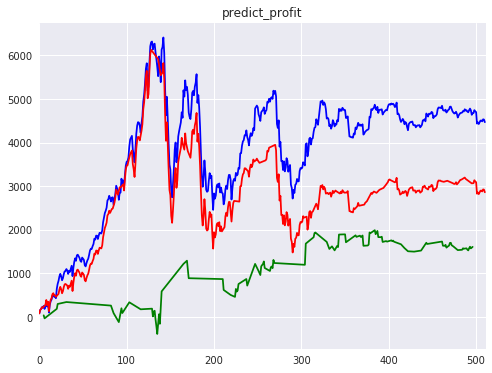

predict_class    0    2  All
real_class                  
0.0             60  170  230
1.0              0    5    5
2.0             57  220  277
All            117  395  512


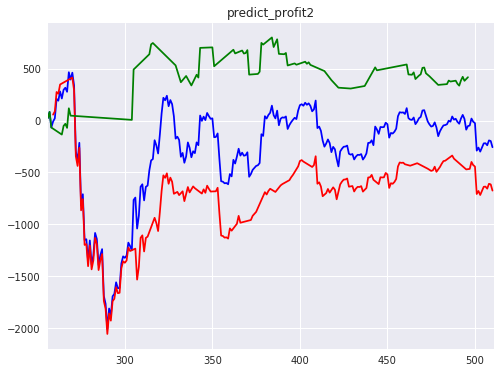

predict_class   0    2  All
real_class                 
0.0            40   83  123
1.0             0    1    1
2.0            37   95  132
All            77  179  256
epochs: 2701, code: 990905
16/64 [======>.......................] - ETA: 0s

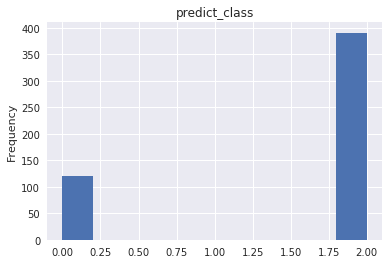

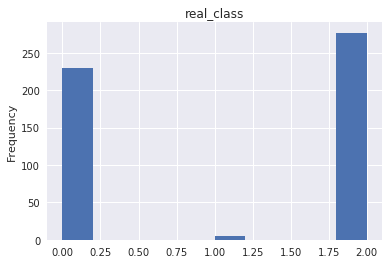

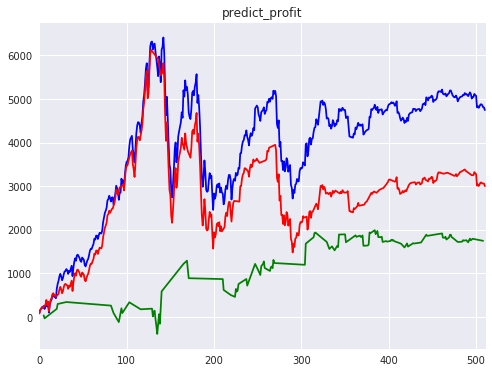

predict_class    0    2  All
real_class                  
0.0             63  167  230
1.0              0    5    5
2.0             58  219  277
All            121  391  512


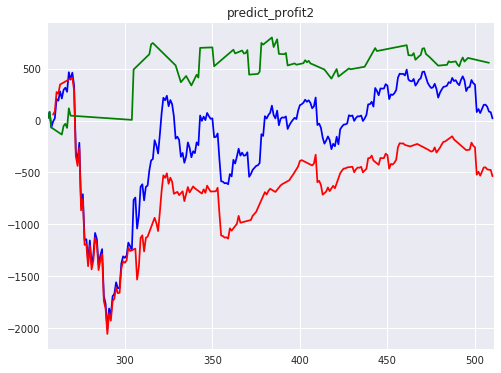

predict_class   0    2  All
real_class                 
0.0            43   80  123
1.0             0    1    1
2.0            38   94  132
All            81  175  256
epochs: 2801, code: 990905
16/64 [======>.......................] - ETA: 0s

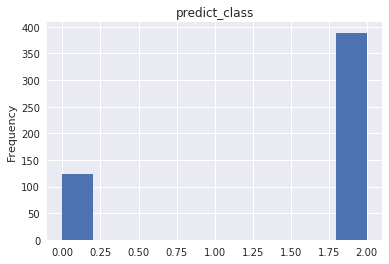

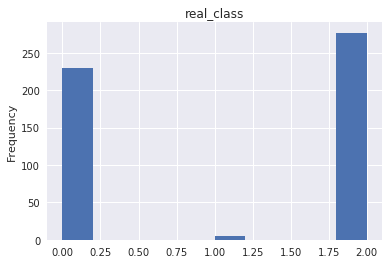

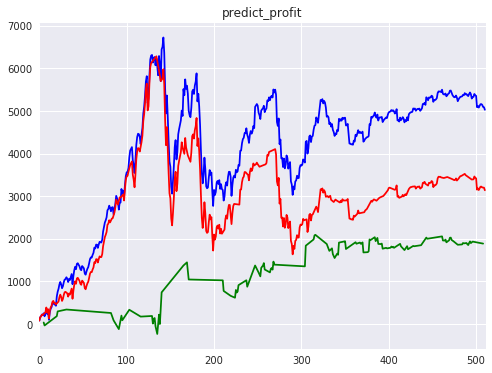

predict_class    0    2  All
real_class                  
0.0             65  165  230
1.0              0    5    5
2.0             58  219  277
All            123  389  512


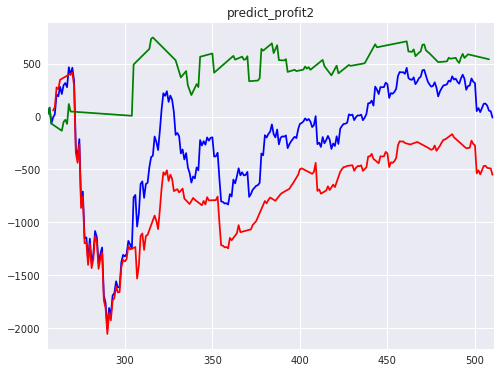

predict_class   0    2  All
real_class                 
0.0            45   78  123
1.0             0    1    1
2.0            39   93  132
All            84  172  256
epochs: 2901, code: 990905
16/64 [======>.......................] - ETA: 0s

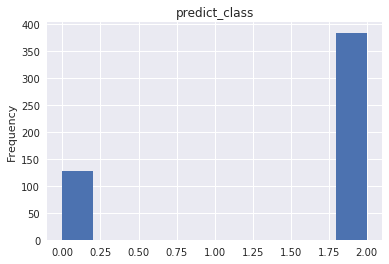

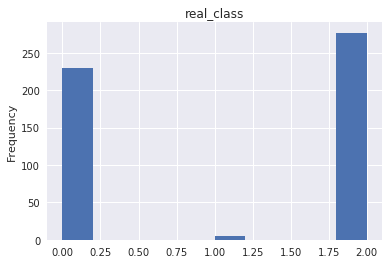

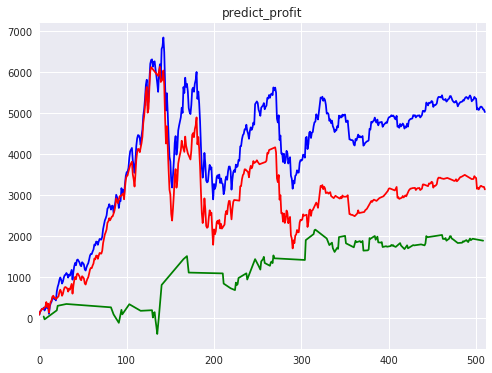

predict_class    0    2  All
real_class                  
0.0             67  163  230
1.0              0    5    5
2.0             61  216  277
All            128  384  512


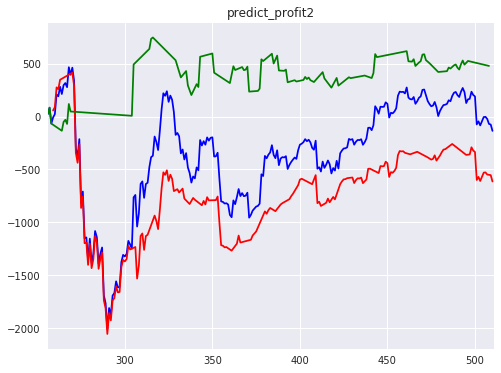

predict_class   0    2  All
real_class                 
0.0            47   76  123
1.0             0    1    1
2.0            42   90  132
All            89  167  256
epochs: 3001, code: 990905
16/64 [======>.......................] - ETA: 0s

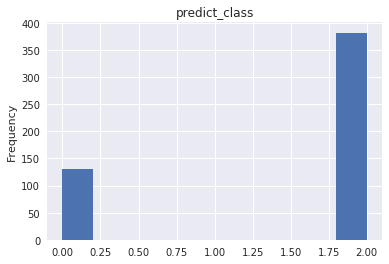

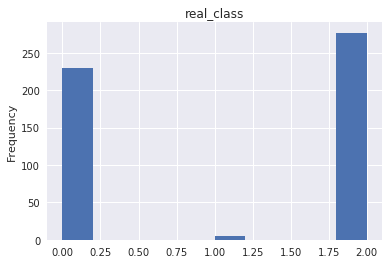

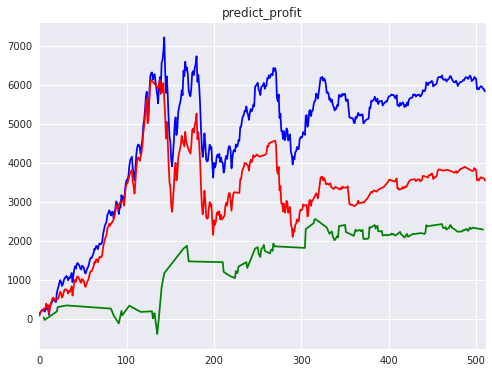

predict_class    0    2  All
real_class                  
0.0             69  161  230
1.0              0    5    5
2.0             61  216  277
All            130  382  512


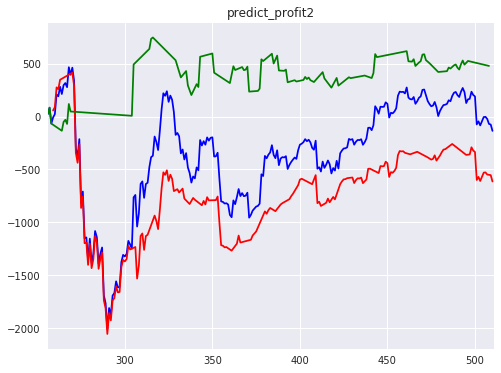

predict_class   0    2  All
real_class                 
0.0            47   76  123
1.0             0    1    1
2.0            42   90  132
All            89  167  256
epochs: 3101, code: 990905
16/64 [======>.......................] - ETA: 0s

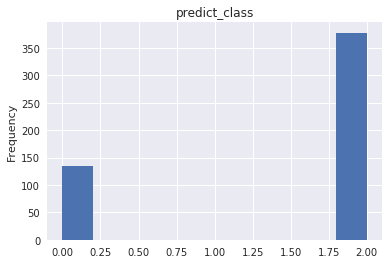

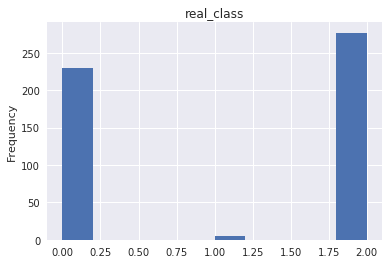

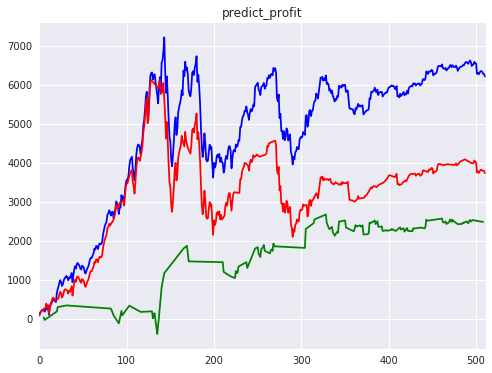

predict_class    0    2  All
real_class                  
0.0             73  157  230
1.0              0    5    5
2.0             61  216  277
All            134  378  512


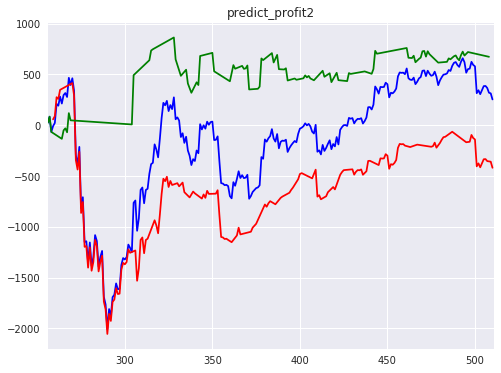

predict_class   0    2  All
real_class                 
0.0            51   72  123
1.0             0    1    1
2.0            42   90  132
All            93  163  256
epochs: 3201, code: 990905
64/64 [==============================] - 0s     
epochs: 3203, code: 990905
16/64 [======>.......................] - ETA: 0s

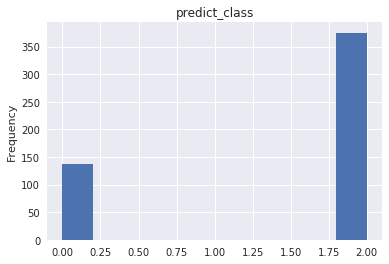

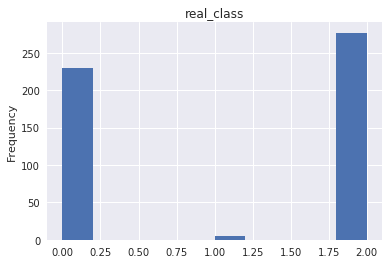

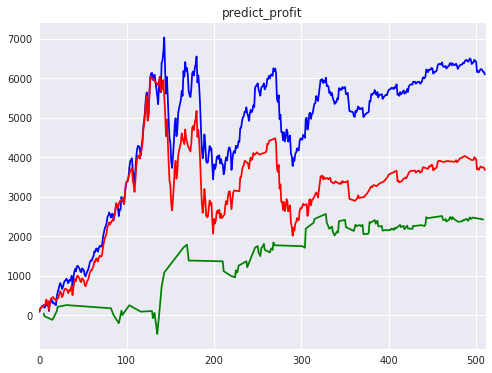

predict_class    0    2  All
real_class                  
0.0             74  156  230
1.0              0    5    5
2.0             63  214  277
All            137  375  512


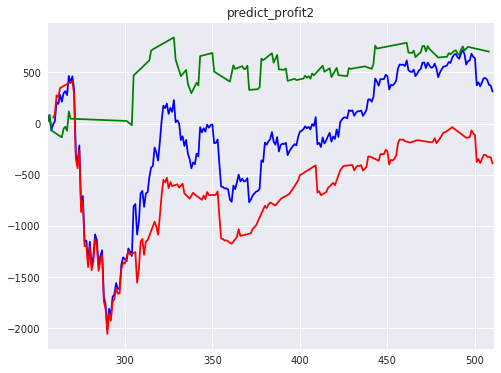

predict_class   0    2  All
real_class                 
0.0            52   71  123
1.0             0    1    1
2.0            43   89  132
All            95  161  256
epochs: 3301, code: 990905
16/64 [======>.......................] - ETA: 0s

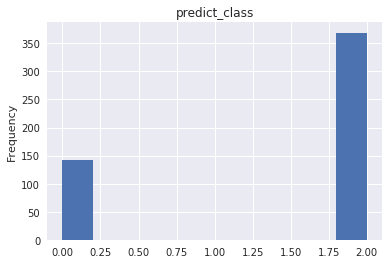

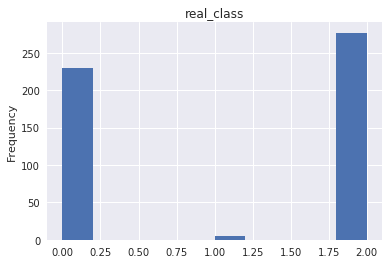

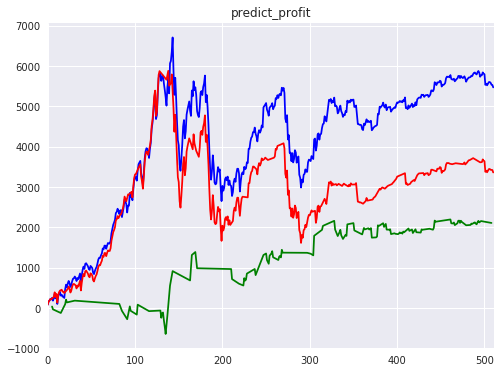

predict_class    0    2  All
real_class                  
0.0             75  155  230
1.0              0    5    5
2.0             68  209  277
All            143  369  512


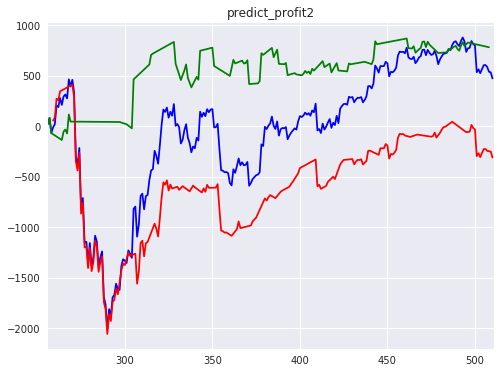

predict_class   0    2  All
real_class                 
0.0            53   70  123
1.0             0    1    1
2.0            45   87  132
All            98  158  256
epochs: 3401, code: 990905
16/64 [======>.......................] - ETA: 0s

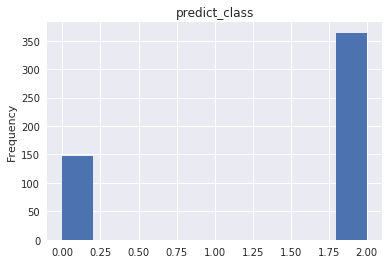

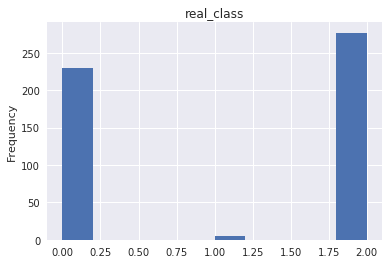

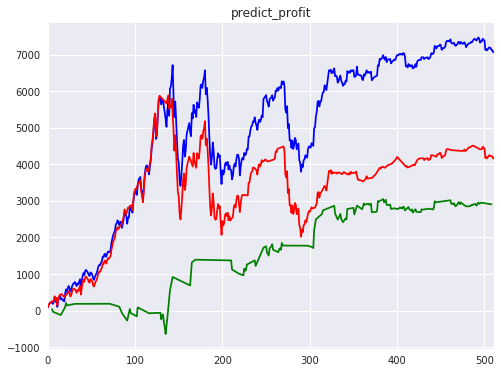

predict_class    0    2  All
real_class                  
0.0             78  152  230
1.0              0    5    5
2.0             70  207  277
All            148  364  512


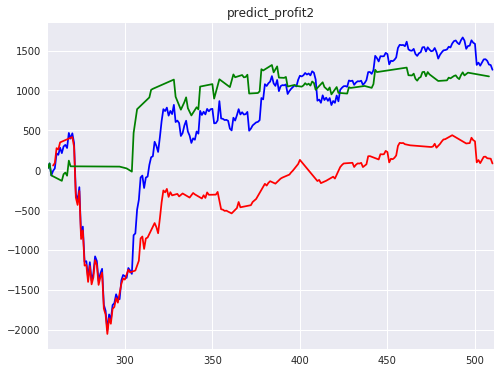

predict_class    0    2  All
real_class                  
0.0             55   68  123
1.0              0    1    1
2.0             48   84  132
All            103  153  256
epochs: 3501, code: 990905
16/64 [======>.......................] - ETA: 0s

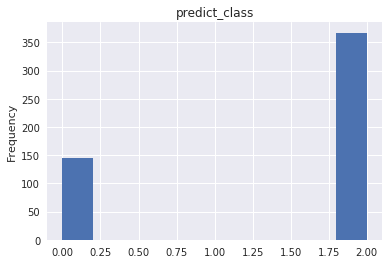

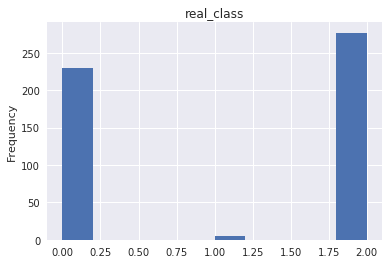

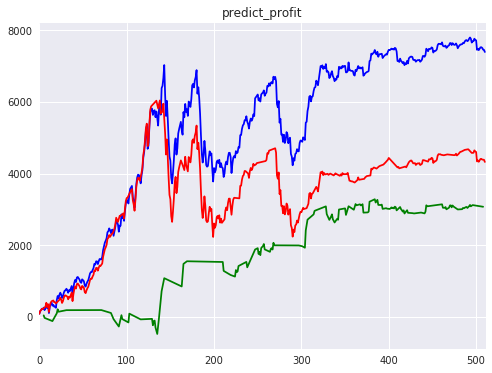

predict_class    0    2  All
real_class                  
0.0             78  152  230
1.0              0    5    5
2.0             67  210  277
All            145  367  512


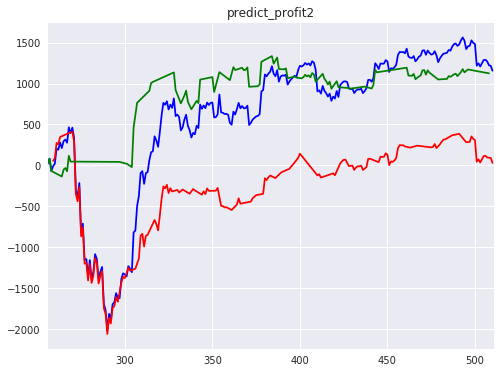

predict_class    0    2  All
real_class                  
0.0             54   69  123
1.0              0    1    1
2.0             46   86  132
All            100  156  256
epochs: 3601, code: 990905
16/64 [======>.......................] - ETA: 0s

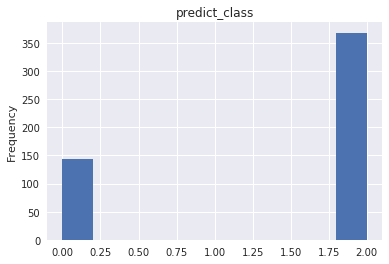

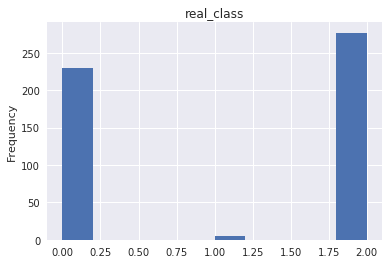

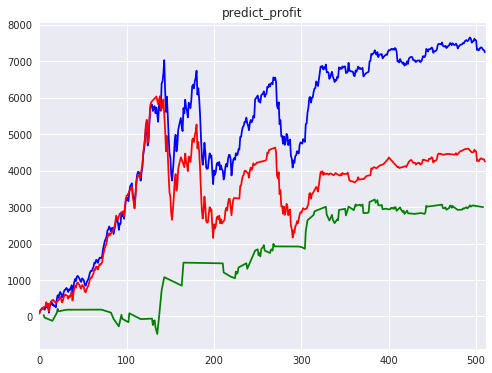

predict_class    0    2  All
real_class                  
0.0             77  153  230
1.0              0    5    5
2.0             67  210  277
All            144  368  512


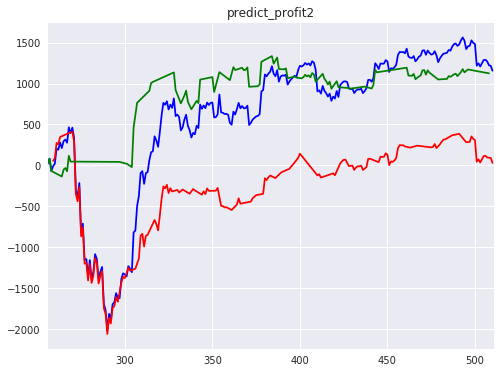

predict_class    0    2  All
real_class                  
0.0             54   69  123
1.0              0    1    1
2.0             46   86  132
All            100  156  256
epochs: 3701, code: 990905
16/64 [======>.......................] - ETA: 0s

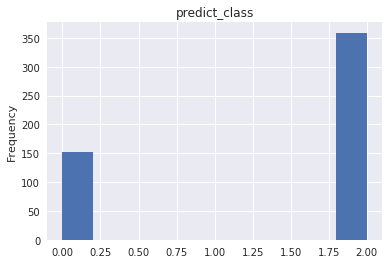

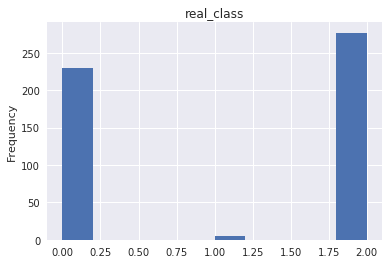

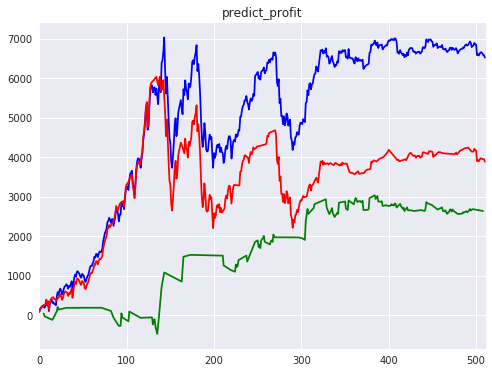

predict_class    0    2  All
real_class                  
0.0             80  150  230
1.0              0    5    5
2.0             73  204  277
All            153  359  512


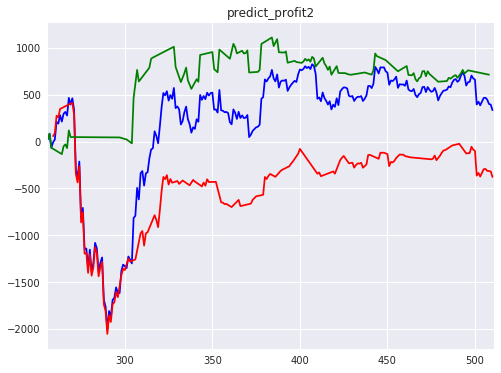

predict_class    0    2  All
real_class                  
0.0             55   68  123
1.0              0    1    1
2.0             52   80  132
All            107  149  256
epochs: 3801, code: 990905
16/64 [======>.......................] - ETA: 0s

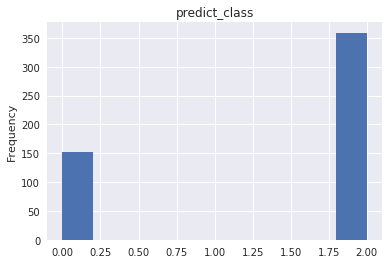

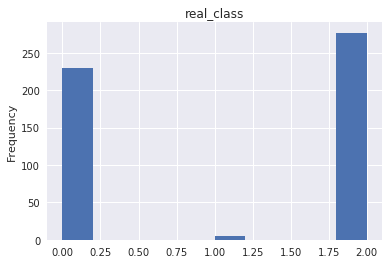

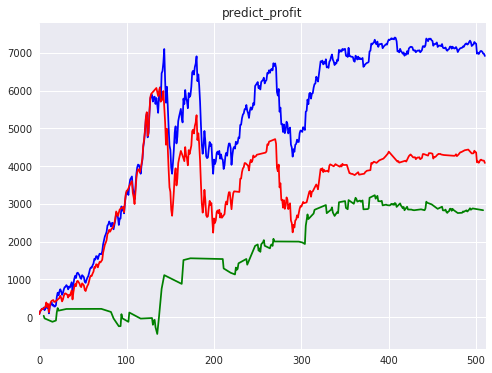

predict_class    0    2  All
real_class                  
0.0             81  149  230
1.0              0    5    5
2.0             72  205  277
All            153  359  512


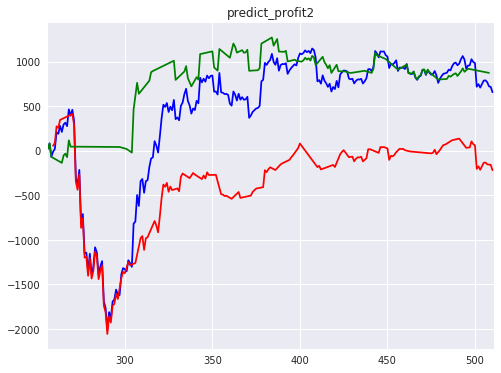

predict_class    0    2  All
real_class                  
0.0             55   68  123
1.0              0    1    1
2.0             51   81  132
All            106  150  256
epochs: 3901, code: 990905
64/64 [==============================] - 0s     
epochs: 3925, code: 990905
16/64 [======>.......................] - ETA: 0s

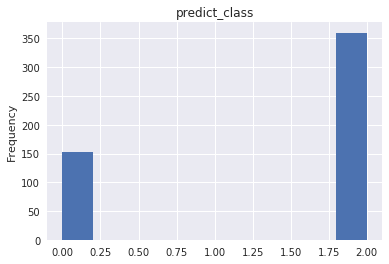

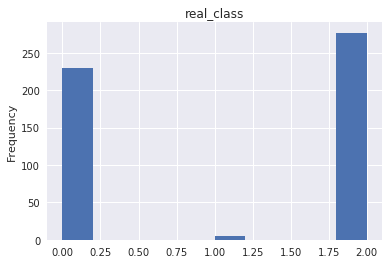

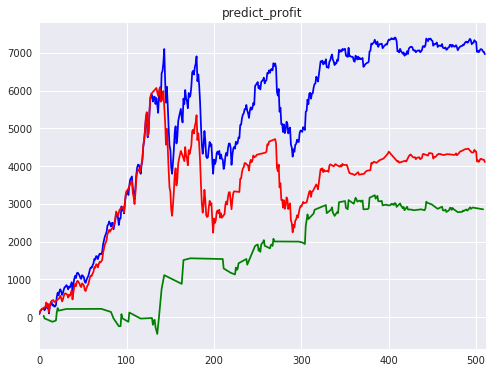

predict_class    0    2  All
real_class                  
0.0             81  149  230
1.0              0    5    5
2.0             71  206  277
All            152  360  512


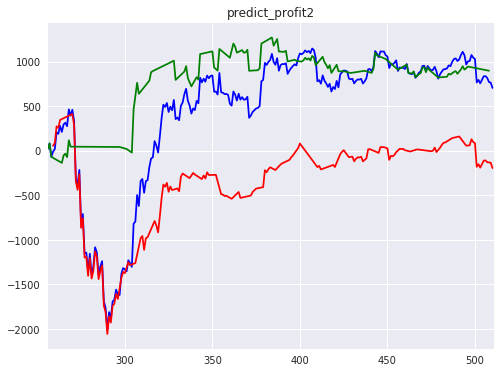

predict_class    0    2  All
real_class                  
0.0             55   68  123
1.0              0    1    1
2.0             50   82  132
All            105  151  256
epochs: 4001, code: 990905
16/64 [======>.......................] - ETA: 0s

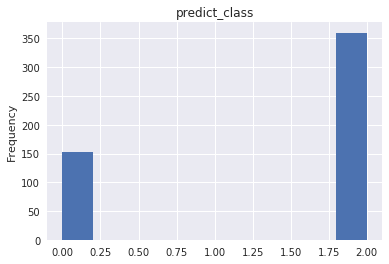

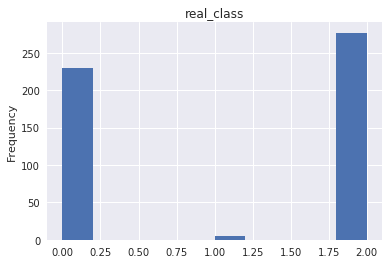

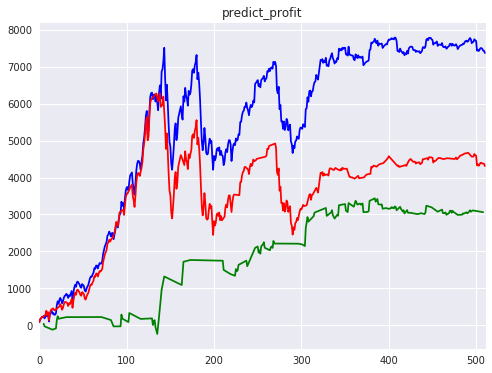

predict_class    0    2  All
real_class                  
0.0             81  149  230
1.0              0    5    5
2.0             71  206  277
All            152  360  512


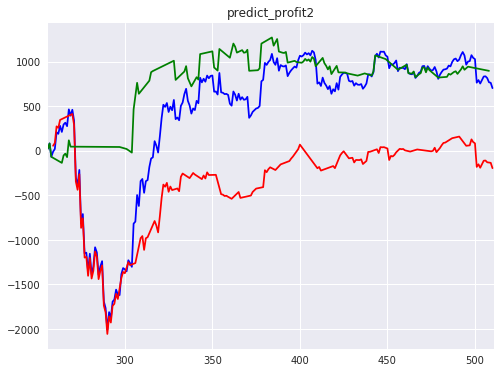

predict_class    0    2  All
real_class                  
0.0             55   68  123
1.0              0    1    1
2.0             51   81  132
All            106  150  256
epochs: 4101, code: 990905
16/64 [======>.......................] - ETA: 0s

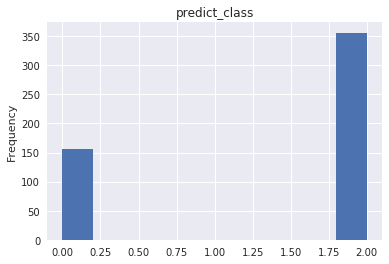

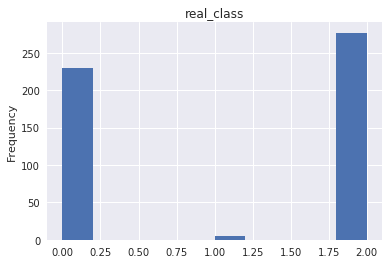

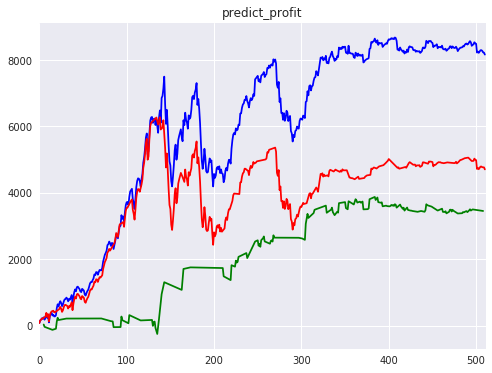

predict_class    0    2  All
real_class                  
0.0             83  147  230
1.0              0    5    5
2.0             73  204  277
All            156  356  512


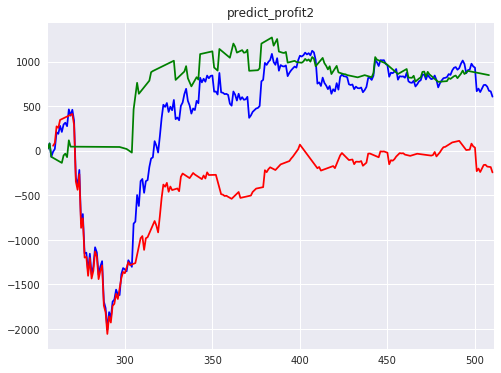

predict_class    0    2  All
real_class                  
0.0             55   68  123
1.0              0    1    1
2.0             53   79  132
All            108  148  256
epochs: 4201, code: 990905
64/64 [==============================] - 0s     
epochs: 4289, code: 990905
16/64 [======>.......................] - ETA: 0s

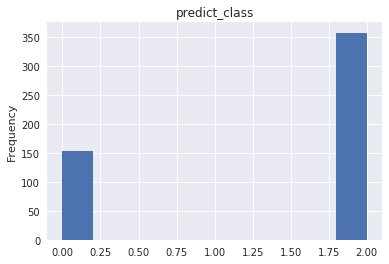

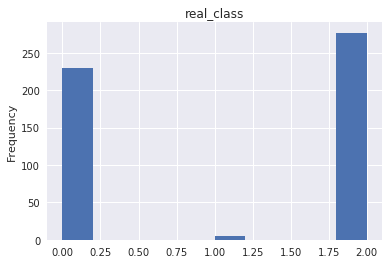

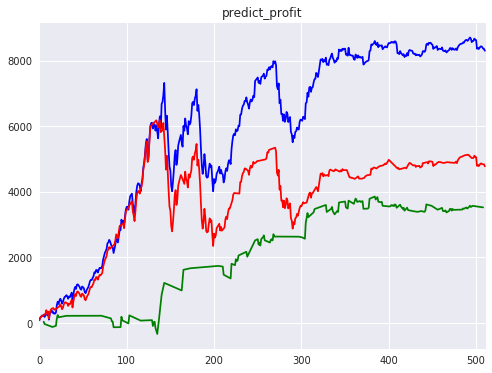

predict_class    0    2  All
real_class                  
0.0             82  148  230
1.0              0    5    5
2.0             72  205  277
All            154  358  512


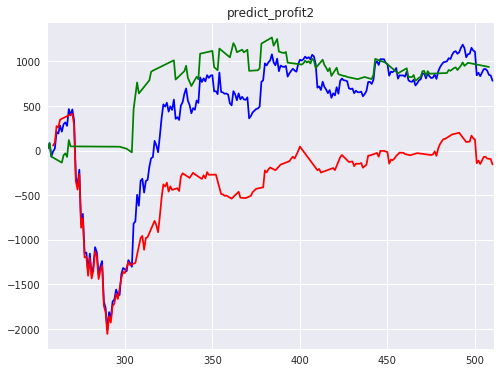

predict_class    0    2  All
real_class                  
0.0             53   70  123
1.0              0    1    1
2.0             51   81  132
All            104  152  256
epochs: 4301, code: 990905
16/64 [======>.......................] - ETA: 0s

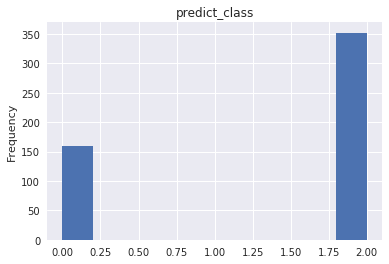

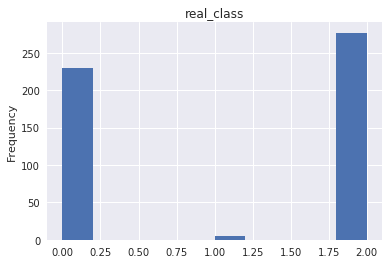

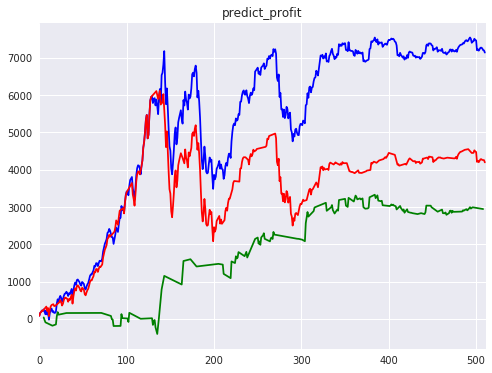

predict_class    0    2  All
real_class                  
0.0             83  147  230
1.0              0    5    5
2.0             77  200  277
All            160  352  512


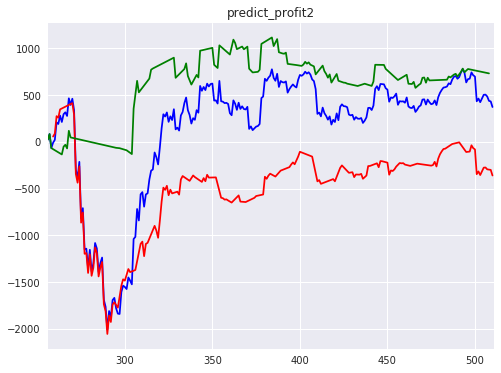

predict_class    0    2  All
real_class                  
0.0             53   70  123
1.0              0    1    1
2.0             53   79  132
All            106  150  256
epochs: 4401, code: 990905
64/64 [==============================] - 0s     
epochs: 4415, code: 990905
16/64 [======>.......................] - ETA: 0s

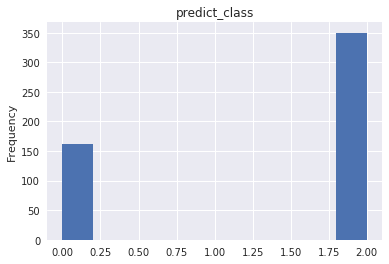

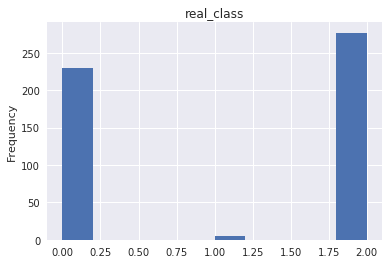

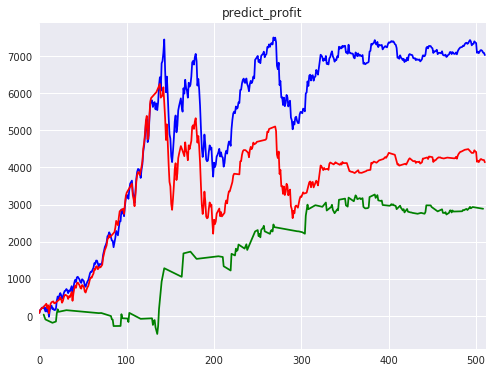

predict_class    0    2  All
real_class                  
0.0             83  147  230
1.0              0    5    5
2.0             79  198  277
All            162  350  512


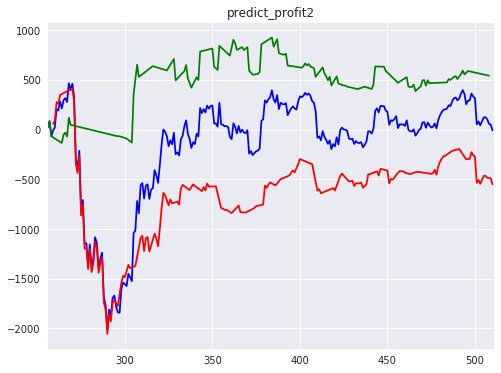

predict_class    0    2  All
real_class                  
0.0             52   71  123
1.0              0    1    1
2.0             54   78  132
All            106  150  256
epochs: 4501, code: 990905
16/64 [======>.......................] - ETA: 0s

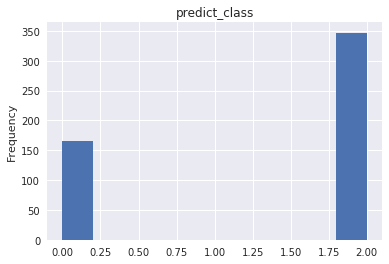

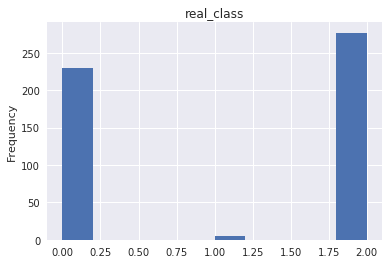

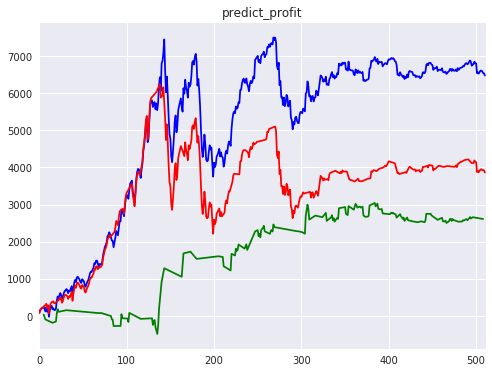

predict_class    0    2  All
real_class                  
0.0             84  146  230
1.0              0    5    5
2.0             81  196  277
All            165  347  512


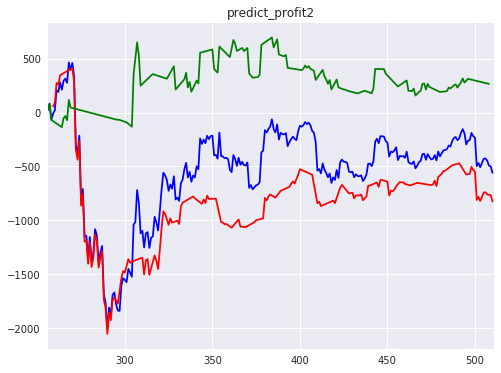

predict_class    0    2  All
real_class                  
0.0             53   70  123
1.0              0    1    1
2.0             56   76  132
All            109  147  256
epochs: 4601, code: 990905
64/64 [==============================] - 0s     
epochs: 4678, code: 990905
16/64 [======>.......................] - ETA: 0s

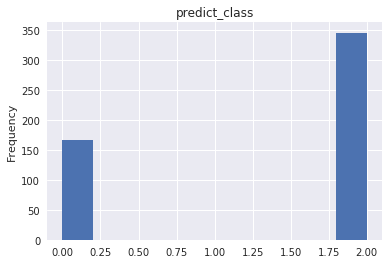

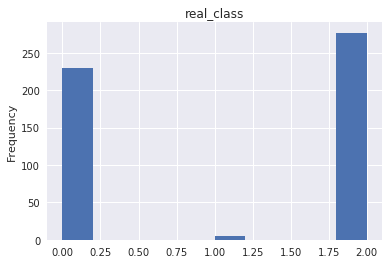

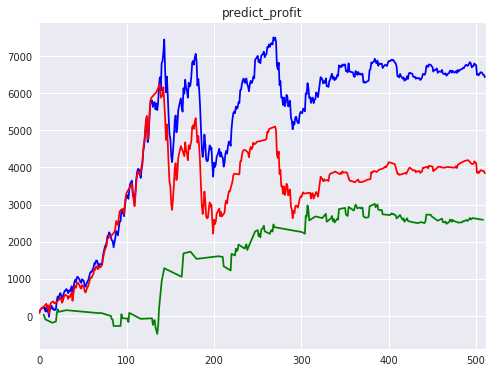

predict_class    0    2  All
real_class                  
0.0             84  146  230
1.0              0    5    5
2.0             82  195  277
All            166  346  512


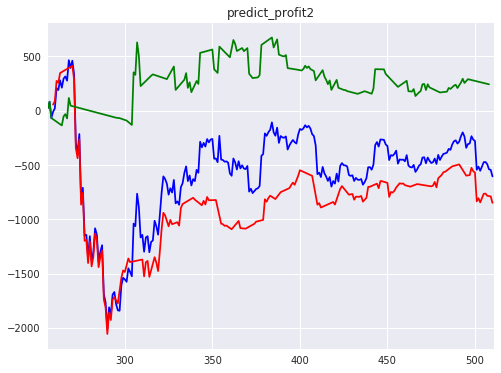

predict_class    0    2  All
real_class                  
0.0             53   70  123
1.0              0    1    1
2.0             57   75  132
All            110  146  256
epochs: 4701, code: 990905
16/64 [======>.......................] - ETA: 0s

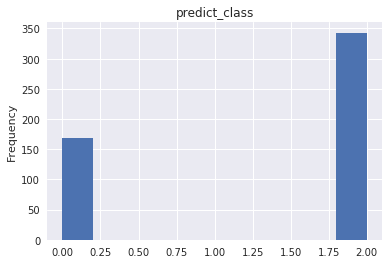

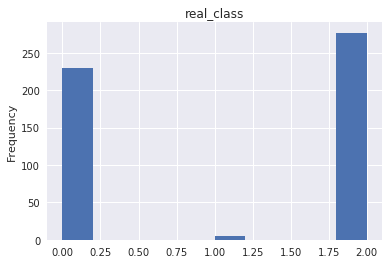

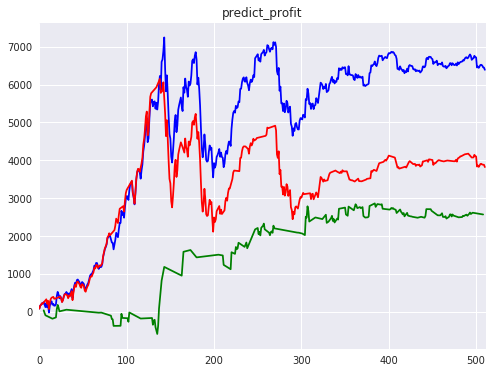

predict_class    0    2  All
real_class                  
0.0             86  144  230
1.0              0    5    5
2.0             83  194  277
All            169  343  512


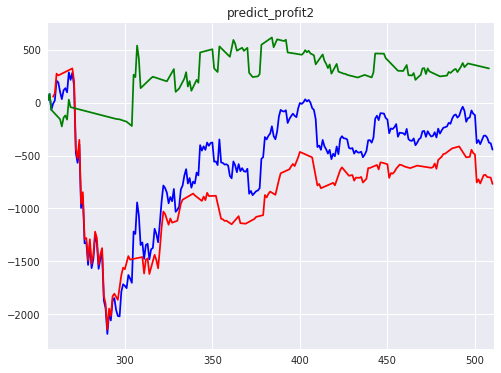

predict_class    0    2  All
real_class                  
0.0             55   68  123
1.0              0    1    1
2.0             57   75  132
All            112  144  256
epochs: 4801, code: 990905
16/64 [======>.......................] - ETA: 0s

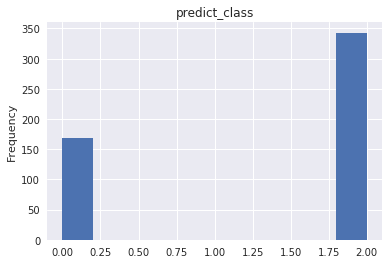

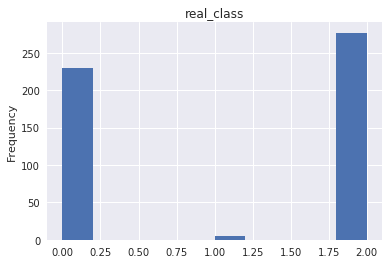

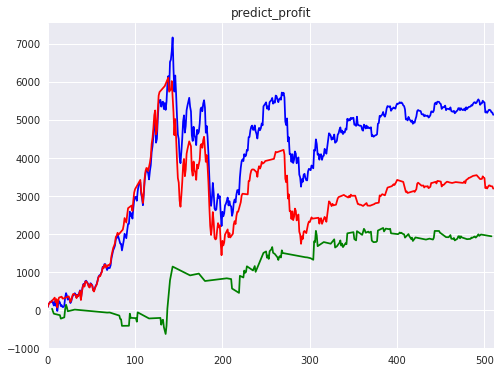

predict_class    0    2  All
real_class                  
0.0             86  144  230
1.0              0    5    5
2.0             83  194  277
All            169  343  512


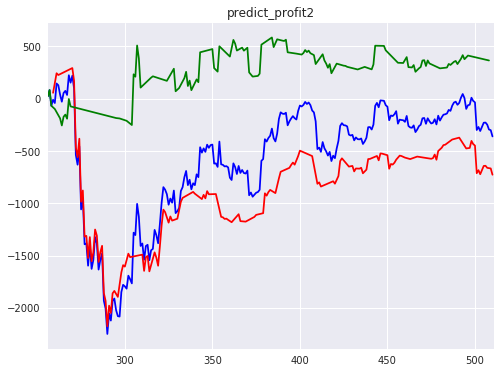

predict_class    0    2  All
real_class                  
0.0             56   67  123
1.0              0    1    1
2.0             56   76  132
All            112  144  256
epochs: 4901, code: 990905
16/64 [======>.......................] - ETA: 0s

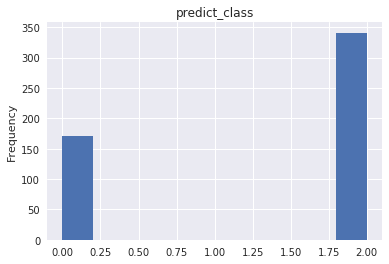

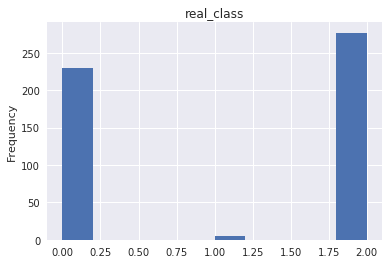

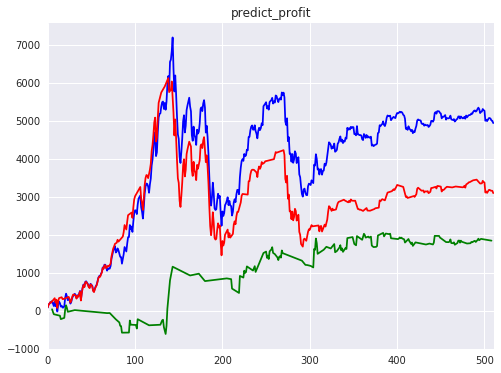

predict_class    0    2  All
real_class                  
0.0             87  143  230
1.0              0    5    5
2.0             84  193  277
All            171  341  512


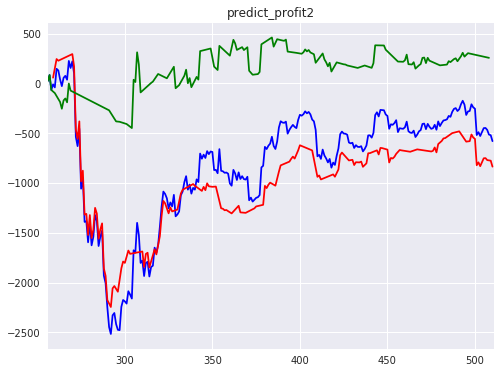

predict_class    0    2  All
real_class                  
0.0             57   66  123
1.0              0    1    1
2.0             57   75  132
All            114  142  256
epochs: 5001, code: 990905
16/64 [======>.......................] - ETA: 0s

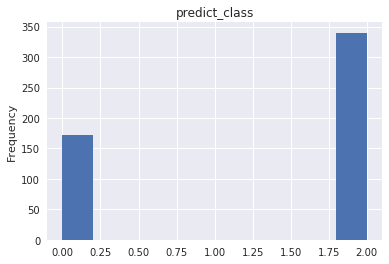

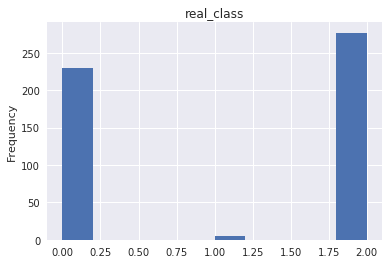

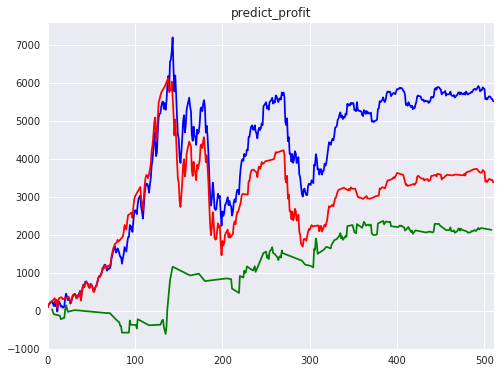

predict_class    0    2  All
real_class                  
0.0             88  142  230
1.0              0    5    5
2.0             84  193  277
All            172  340  512


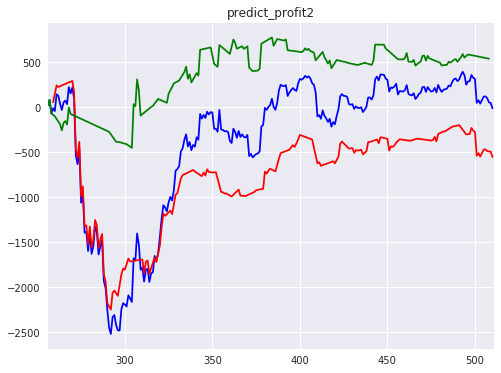

predict_class    0    2  All
real_class                  
0.0             58   65  123
1.0              0    1    1
2.0             57   75  132
All            115  141  256
epochs: 5101, code: 990905
16/64 [======>.......................] - ETA: 0s

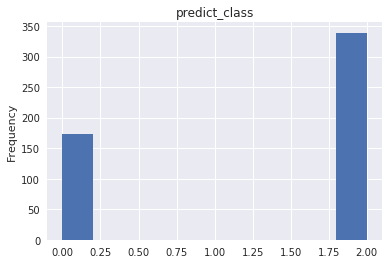

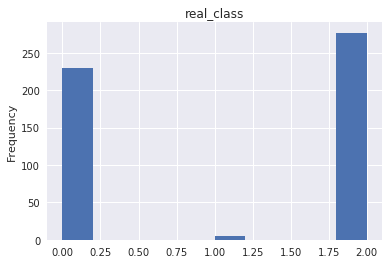

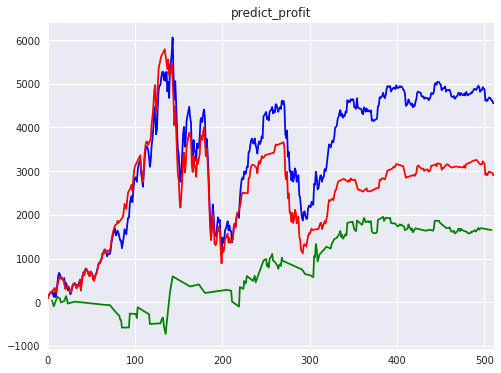

predict_class    0    2  All
real_class                  
0.0             88  142  230
1.0              0    5    5
2.0             85  192  277
All            173  339  512


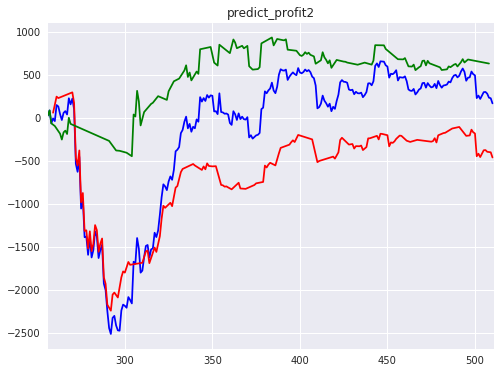

predict_class    0    2  All
real_class                  
0.0             59   64  123
1.0              0    1    1
2.0             58   74  132
All            117  139  256
epochs: 5201, code: 990905
16/64 [======>.......................] - ETA: 0s

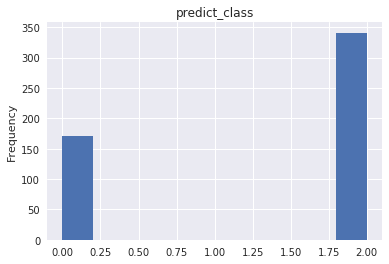

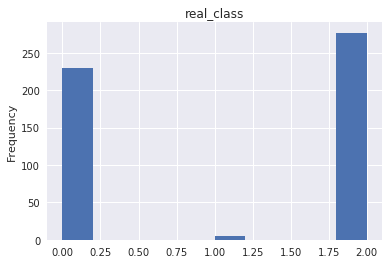

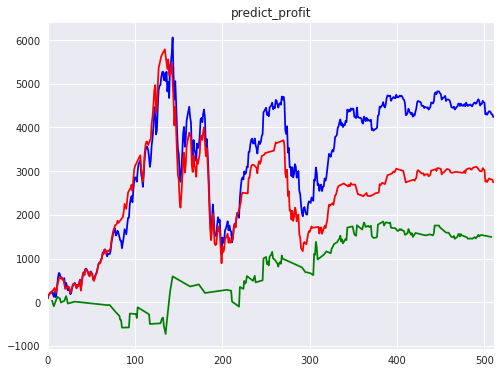

predict_class    0    2  All
real_class                  
0.0             86  144  230
1.0              0    5    5
2.0             85  192  277
All            171  341  512


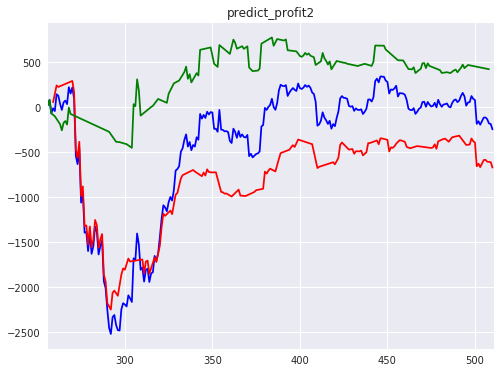

predict_class    0    2  All
real_class                  
0.0             56   67  123
1.0              0    1    1
2.0             58   74  132
All            114  142  256
epochs: 5301, code: 990905
64/64 [==============================] - 0s     
epochs: 5396, code: 990905
16/64 [======>.......................] - ETA: 0s

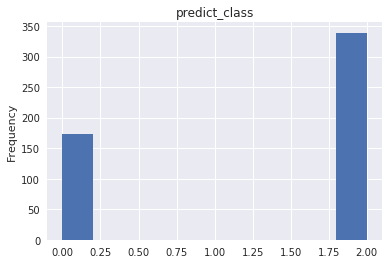

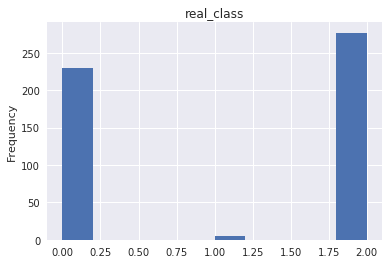

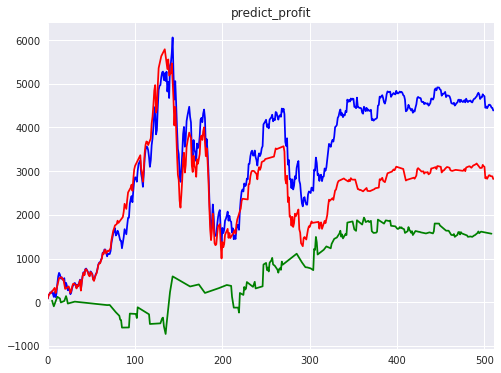

predict_class    0    2  All
real_class                  
0.0             87  143  230
1.0              1    4    5
2.0             85  192  277
All            173  339  512


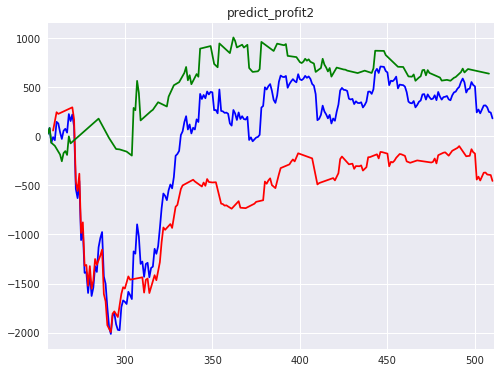

predict_class    0    2  All
real_class                  
0.0             56   67  123
1.0              0    1    1
2.0             57   75  132
All            113  143  256
epochs: 5401, code: 990905
16/64 [======>.......................] - ETA: 0s

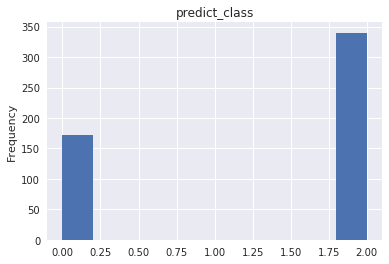

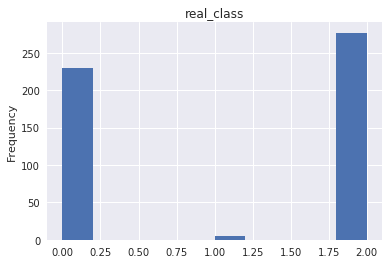

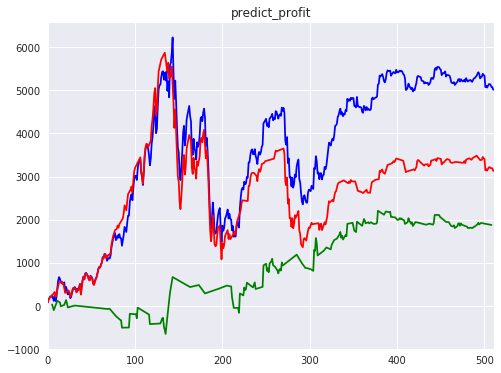

predict_class    0    2  All
real_class                  
0.0             88  142  230
1.0              1    4    5
2.0             83  194  277
All            172  340  512


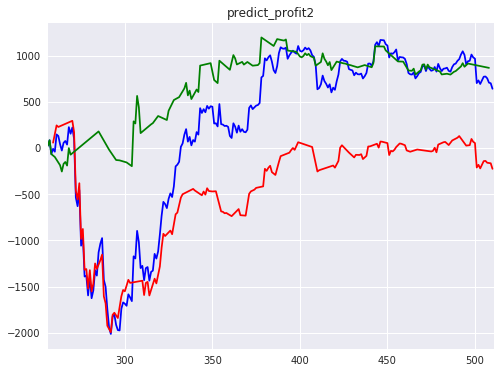

predict_class    0    2  All
real_class                  
0.0             57   66  123
1.0              0    1    1
2.0             56   76  132
All            113  143  256
epochs: 5501, code: 990905
16/64 [======>.......................] - ETA: 0s

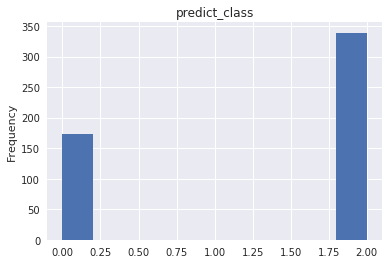

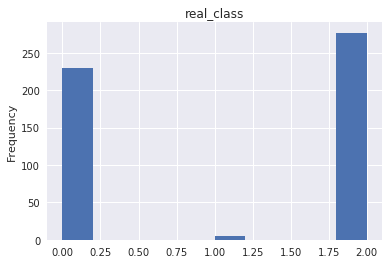

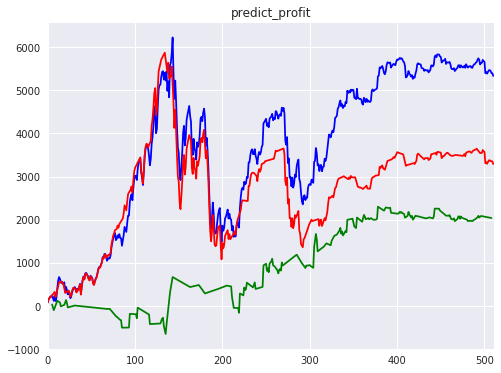

predict_class    0    2  All
real_class                  
0.0             90  140  230
1.0              1    4    5
2.0             82  195  277
All            173  339  512


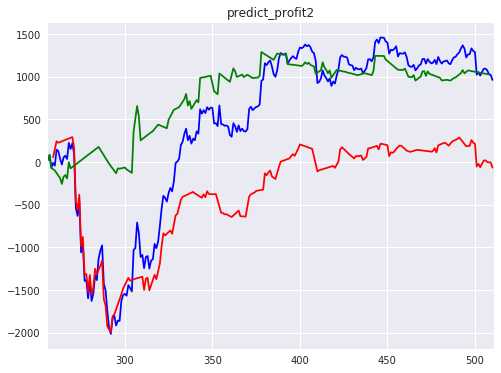

predict_class    0    2  All
real_class                  
0.0             59   64  123
1.0              0    1    1
2.0             55   77  132
All            114  142  256
epochs: 5601, code: 990905
16/64 [======>.......................] - ETA: 0s

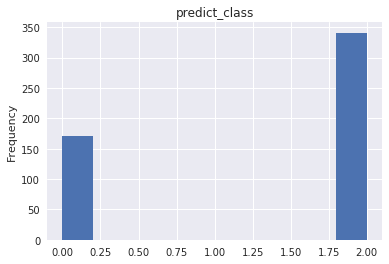

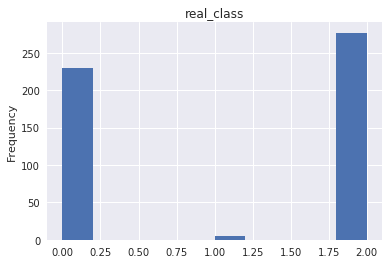

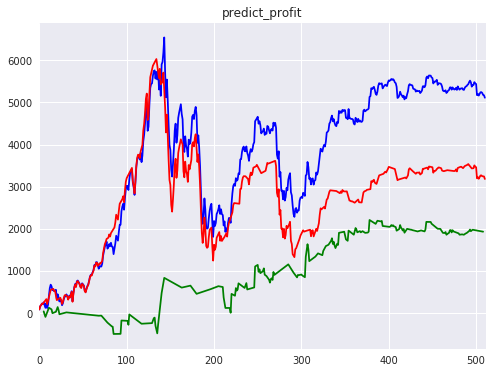

predict_class    0    2  All
real_class                  
0.0             88  142  230
1.0              1    4    5
2.0             82  195  277
All            171  341  512


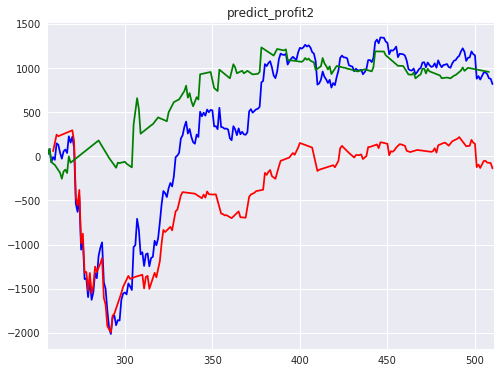

predict_class    0    2  All
real_class                  
0.0             58   65  123
1.0              0    1    1
2.0             56   76  132
All            114  142  256
epochs: 5701, code: 990905
16/64 [======>.......................] - ETA: 0sepochs: 5728, code: 990905


In [ ]:
epochs = 20000
train(model, train_set, test_set, epochs, batch_size)

In [ ]:
# history = model.fit(train_X, train_Y, epochs=100, batch_size=batch_size, validation_data=(test_X, test_Y), verbose=1, shuffle=False)

In [ ]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(history.history['acc'], label='train')
# plt.plot(history.history['val_acc'], label='test')
# plt.legend()
# plt.show()

In [ ]:
# test_X, test_Y = test_set[990905]

In [ ]:
# predict_Y=model.predict(x=test_X, batch_size=batch_size)
# predict_class = np.argmax(predict_Y,axis=2)

In [35]:
def compare_test_set(data_all, code):
    begin_date = df_test_set[code].index.get_level_values('date')[0]
    end_date = df_test_set[code].index.get_level_values('date')[-1]
    
    query_str = 'code=={0}'.format(code)
    data_code = data_all.query(query_str)
    data_cleaned = data_clean(data_code)
    
    cond = (data_cleaned.index.get_level_values('code') == code) & (data_cleaned.index.get_level_values('date') <= end_date) & (data_cleaned.index.get_level_values('date') >= begin_date)
    test_data_orig = data_cleaned.loc[cond]
    
    cond = (data_set_norm[code].index.get_level_values('code') == code) & (data_set_norm[code].index.get_level_values('date') <= end_date) & (data_set_norm[code].index.get_level_values('date') >= begin_date)
    test_data_norm_match = data_set_norm[code].loc[cond]
    
    compare_data = pd.DataFrame(index=test_data_orig.index)
    compare_data['close'] = test_data_orig['close']
    compare_data['real_class'] = test_data_norm_match['class']
    return compare_data
    

In [36]:
def color(x):
    c = 'm'
    if x < 0:
        c = 'g'
    elif x > 0:
        c = 'r'
    else:
        c = 'b'
    return c

In [37]:
def predict_profit(x):
    profit = 0
    if x['predict_class'] == 2:
        profit = x['profit']
    elif x['predict_class'] == 0:
        profit = -x['profit']
    else:
        profit = 0
    return profit

In [38]:
# column: true_class predict_class
def class_compare(df):
    return pd.crosstab(df.real_class, df.predict_class, margins=True) 

In [ ]:
code=990905
cmp_predict = compare_test_set(data_all, code)

In [ ]:
cmp_predict['predict_class'] = predict_class.reshape((-1, ))

In [ ]:
cmp_predict['diff'] = cmp_predict['predict_class'] - cmp_predict['real_class']

In [ ]:
cmp_predict.head()

In [ ]:
cmp_predict = cmp_predict.reset_index()

In [ ]:
def color(x):
    c = 'm'
    if x < 0:
        c = 'g'
    elif x > 0:
        c = 'r'
    else:
        c = 'b'
    return c

In [ ]:
cmp_predict['color'] = cmp_predict['diff'].map(color)

In [ ]:
# cmp_predict.plot(kind='scatter', x='index', y='close', s=60, c=cmp_predict.color, figsize=(8, 6))
# plt.show()

In [ ]:
cmp_predict.tail()

In [ ]:
cmp_predict['predict_class'].plot.hist(title='predict_class')

In [ ]:
cmp_predict['real_class'].plot.hist(title='real_class')

In [ ]:
cmp_predict['next_close'] = cmp_predict['close'].shift(-1)

In [ ]:
cmp_predict['profit'] = cmp_predict['next_close'] - cmp_predict['close']

In [ ]:
cmp_predict.head()

In [ ]:
def predict_profit(x):
    profit = 0
    if x['predict_class'] == 2:
        profit = x['profit']
    elif x['predict_class'] == 0:
        profit = -x['profit']
    else:
        profit = 0
    return profit

In [ ]:
cmp_predict['predict_profit'] = cmp_predict.apply(predict_profit, axis=1)
cmp_predict['predict_profit'].cumsum().plot(figsize=(8, 6), color='b', title='predict_profit')
cmp_predict[cmp_predict['predict_class']==2]['predict_profit'].cumsum().plot(color='r')
cmp_predict[cmp_predict['predict_class']==0]['predict_profit'].cumsum().plot(color='g')

In [ ]:
cmp_predict['predict_profit'].cumsum().plot(figsize=(8, 6), color='b', title='predict_profit')

In [ ]:
cmp_predict.head(100).tail(5)

In [ ]:
cmp_predict.head(100).tail(5)['predict_profit'].cumsum().plot(figsize=(8, 6), color='b', title='predict_profit')

## 性能评估

### 类预测比较

### 类分布

In [ ]:
# column: true_class predict_class
def class_compare(df):
    return pd.crosstab(df.real_class, df.predict_class, margins=True) 

In [ ]:
class_compare(cmp_predict)

### 利润

In [ ]:
# column: close signal
def portfolio_return_ration(df, direction="both"):
    def profit(x):
        # 归一化
        x[x['signal'] < -1]['signal'] = -1
        x[x['signal'] > 1]['signal'] = 1

        if direction == "long":
            x[x['signal'] < 0]['signal'] = 0
        elif direction == "short":
            x[x['signal'] > 0]['signal'] = 0
            
        x['profit'] = x['diff'] * x['signal']
        return x

    df_tmp = pd.DataFrame()
    pre_close = df['close'].shift(1)
    df_tmp['diff'] =  df['close'] - pre_close
    df_tmp['signal'] = df['signal']
    
    df_tmp['profit'] = df.apply(profit, axis=1)
    return (df_tmp['profit']+1).cumprod()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0, 20, 100)
# y = np.sin(x)
# z = x + 20 * y

# scaled_z = (x - x.min())
# colors = plt.cm.coolwarm(x)

# plt.scatter(x, y, marker='+', edgecolors=colors, s=150, linewidths=4)
# plt.show()